# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

**Project Overview**

This capstone project focuses on solving a customer segmentation analysis and developing a predictive model for the company Arvato. The company's client, who are we solving this problem for, is running a mail-order business. The company has provided extensive datasets containing detailed information about their past customers as well as the general population, who are not their customers. This is mostly demographic data about the German population. The goal of this project is to help Arvato identify the key differences and factors that determine whether someone is a customer or not. Gaining these insights can lead to a more targeted and efficient mailout campaign, attracting new customers and potentially generating significant revenue for the company.This project involves complex analysis, combining both unsupervised and supervised data science techniques. It begins with segmentation analysis to better understand the data, followed by the development of a predictive model capable of classifying potential customers.

**Problem Statement**

"Can German population demographic data be leveraged to identify the factors that distinguish customers from non-customers and develop a model to predict potential customers?"

This project addresses two main challenges:

**1. Customer Segmentation Report**<br>
The primary focus of this analysis is identifying the differences between customer and non-customer data. Unsupervised methods will be employed to uncover these distinctions. The expected outcome is a visual assessment of the features that highlight and quantify the differences between the groups.

**2. Predictive Model Development**<br>
A classifier will be trained on the provided data to predict potential customers. Standard classifier evaluation metrics (AUC-ROC) will be used to assess model performance. Additionally, the most important features of the selected model will be analyzed, with a discussion on how they align with insights derived from the clustered datasets.

**Metrics**<br>
For the segmentation analysis, the primary evaluation will focus on the visual assessment of cluster similarity across the customer and non-customer groups. The goal is to identify and interpret differences in demographic and behavioral patterns with visualizzation tools like barplots and scatterplots.

For the predictive model, the chosen metrics are Precision-Recall (PR) curves and AUC-PR (Area Under the PR Curve). These metrics are particularly suited for this project because the dataset is expected to be severely imbalanced, with far fewer customers (positive class) than non-customers (negative class). PR curves emphasize the performance on the minority class by evaluating the trade-off between precision (how many predicted positives are actually correct) and recall (how well the model captures the positive class).

In [411]:
# Import necessary libraries

import numpy as np
import pandas as pd
from typing import List, Tuple
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, average_precision_score
import seaborn as sns
import warnings
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve
from xgboost import XGBClassifier
import shap

%matplotlib inline
warnings.filterwarnings("ignore")

In [412]:
# All helper functions are defined here

def show_memory_usage(df:pd.DataFrame)->None:
    """Show memory usage for a single dataframe."""
    memory_usage_per_column = df.memory_usage(deep=True)
    total_memory_usage = memory_usage_per_column.sum()
    print(f"\nTotal memory usage: {total_memory_usage / 1024:.2f} KB")

def reduce_memory_usage(df:pd.DataFrame)->pd.DataFrame:
    """
    Iterate through all the columns of a DataFrame and modify the data type
    to reduce memory usage until no further improvement is achieved.

    Parameters:
    df (pd.DataFrame): The DataFrame to optimize.

    Returns:
    pd.DataFrame: The optimized DataFrame with reduced memory usage.
    """
    previous_mem = df.memory_usage(deep=True).sum() / 1024**2
    iteration = 0

    while True:
        iteration += 1
        print(f"Iteration {iteration}: Initial memory usage: {previous_mem:.2f} MB")

        for col in df.columns:
            col_type = df[col].dtype

            if pd.api.types.is_numeric_dtype(col_type):
                if pd.api.types.is_integer_dtype(col_type):
                    df[col] = pd.to_numeric(df[col], downcast='integer')
                else:
                    df[col] = pd.to_numeric(df[col], downcast='float')

            elif pd.api.types.is_object_dtype(col_type):
                num_unique_values = df[col].nunique()
                num_total_values = len(df[col])
                if num_unique_values / num_total_values < 0.5:
                    df[col] = df[col].astype('category')

        current_mem = df.memory_usage(deep=True).sum() / 1024**2
        print(f"Iteration {iteration}: Optimized memory usage: {current_mem:.2f} MB")
        print(f"Reduced by {(previous_mem - current_mem) / previous_mem * 100:.1f}%")

        if current_mem == previous_mem:
            break
        else:
            previous_mem = current_mem

    return df

def plot_nan_percentage(df:pd.DataFrame, max_columns:int =50, height:int =600, width:int = 800)-> None:
    """
    Creates an interactive bar chart of NaN percentages in a DataFrame, sorted from highest to lowest.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        max_columns (int): Maximum number of columns to display in the chart.
        height (int): The height of the plot.
        width (int): The width of the plot.
    """
    nan_percentage = df.isna().mean() * 100
    nan_percentage_sorted = nan_percentage.sort_values(ascending=False)[:max_columns]
    
    nan_df = nan_percentage_sorted.reset_index()
    nan_df.columns = ['Column', 'NaN Percentage']
    
    fig = px.bar(
        nan_df,
        x='Column',
        y='NaN Percentage',
        title=f'Percentage of NaN Values per Column (Top {max_columns})',
        labels={'NaN Percentage': 'NaN Percentage (%)', 'Column': 'Columns'},
        text='NaN Percentage'
    )
    
    fig.update_traces(
        texttemplate='%{text:.2f}%', 
        textposition='outside',
        marker=dict(line=dict(color='black', width=1.5))
    )
    
    fig.update_layout(
        xaxis_tickangle=45,
        xaxis_title="Columns",
        yaxis_title="NaN Percentage (%)",
        margin=dict(l=40, r=40, t=40, b=40),
        height=height,
        width=width
    )
    
    fig.show()

def compare_dataframe_cols(df1:pd.DataFrame, df2:pd.DataFrame)->None:
    """
    Compares the columns of two DataFrames and prints the columns that are not common to both.
    
    Args:
        df1 (pd.DataFrame): The first DataFrame.
        df2 (pd.DataFrame): The second DataFrame.
    """
    columns_df1 = set(df1.columns)
    columns_df2 = set(df2.columns)
    
    unique_to_df1 = columns_df1 - columns_df2
    unique_to_df2 = columns_df2 - columns_df1
    
    non_common_columns = list(unique_to_df1.union(unique_to_df2))
    
    print("Columns not common to both DataFrames:", non_common_columns)

def plot_column_histogram(df:pd.DataFrame, column_name:str, bins:int =10, title:str =None, xlabel:str =None, ylabel:str="Frequency")-> None:
    """
    Creates a histogram for a single column of a DataFrame using Matplotlib.
    
    :param df: pandas DataFrame
    :param column_name: str, name of the column to plot
    :param bins: int, number of bins (default is 10)
    :param title: str, title of the plot (optional)
    :param xlabel: str, label for the x-axis (optional, defaults to column name)
    :param ylabel: str, label for the y-axis (default is "Frequency")
    """
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
    
    plt.hist(df[column_name], bins=bins, edgecolor='black', alpha=0.7)
    
    plt.title(title if title else f"Histogram of {column_name}")
    plt.xlabel(xlabel if xlabel else column_name)
    plt.ylabel(ylabel)
    
    plt.show()

def find_highly_correlated_pairs(df:pd.DataFrame, threshold:int=0.8)->List:
    """
    Finds unique pairs of columns with correlations above a specified threshold, 
    excluding non-numerical (e.g., object) columns.

    Args:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): Minimum absolute correlation value.

    Returns:
        list of tuples: Unique pairs of column names with high correlations.
    """
    numerical_df = df.select_dtypes(include=['number'])
    corr_matrix = numerical_df.corr()
    
    correlated_pairs = []

    for col1 in corr_matrix.columns:
        for col2 in corr_matrix.columns:
            if col1 < col2 and abs(corr_matrix.loc[col1, col2]) > threshold:
                correlated_pairs.append((col1, col2, corr_matrix.loc[col1, col2]))
    
    return correlated_pairs

def split_column(df:pd.DataFrame, base_col:str, num_col:str, letter_col:str)->pd.DataFrame:
    """
    Splits a column containing mixed numeric and alphabetic values into two separate columns.
    Handles NaN values gracefully and ensures numeric column uses NaN for missing values.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the column to split.
        base_col (str): The name of the column to split.
        num_col (str): The name of the new column to store the numeric part.
        letter_col (str): The name of the new column to store the alphabetic part.
    
    Returns:
        pd.DataFrame: The DataFrame with the new columns added.
    """
    df[num_col] = df[base_col].astype(str).str.extract(r'(\d+)').astype(float)
    df[letter_col] = df[base_col].astype(str).str.extract(r'([A-Za-z]+)').replace('nan', np.nan)
    
    return df

def plot_nan_count_per_row(df:pd.DataFrame, height:int =6, width:int =10, red_line_value:int =None, title:str = "population")->None:
    """
    Creates a line chart of NaN counts in each row of a DataFrame, sorted in descending order.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        height (int): The height of the plot.
        width (int): The width of the plot.
        red_line_value (int, optional): Value at which to display a horizontal red line.
    """
    nan_counts = df.isna().sum(axis=1)
    nan_counts_sorted = nan_counts.sort_values(ascending=False).reset_index(drop=True)
    
    plt.figure(figsize=(width, height))
    plt.plot(nan_counts_sorted, color='skyblue', marker='o')
    plt.xlabel('Row Index (Sorted)')
    plt.ylabel('Number of NaN Values')
    plt.title(f'Number of NaN Values per Row - {title}')
    
    if red_line_value is not None:
        plt.axhline(y=red_line_value, color='red', linestyle='--', linewidth=1.5, label=f'Borderline at {red_line_value}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def print_unique_values(df:pd.DataFrame, column_name:str)->None:
    """Print unique values of a dataframe."""
    if column_name in df.columns:
        unique_values = df[column_name].unique()
        print(f"Unique values in column '{column_name}':")
        print(unique_values)

def plot_kmeans_with_pca(sse:pd.DataFrame, max_clusters:int =15, title:str ='K-means with PCA Clustering', horizontal_line_at:int =None)->None:
    """
    Plots the Within-Cluster Sum of Squares (WCSS) for different numbers of clusters using K-means after PCA.
    
    Args:
    sse: list or array of WCSS values for different numbers of clusters.
    max_clusters: int, optional (default=15). The maximum number of clusters to display on the x-axis.
    title: str, optional. The title of the plot.
    horizontal_line_at: float, optional. If provided, plots a horizontal line at this y-value.
    """
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, max_clusters + 1), sse, marker='D', linestyle='-', color='teal', linewidth=2, markersize=8)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Number of Clusters (k)', fontsize=14)
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=14)
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    
    if horizontal_line_at is not None:
        plt.axhline(y=horizontal_line_at, color='red', linestyle='--', linewidth=1.5)
        plt.text(1, horizontal_line_at + (0.02 * max(sse)), f'WCSS threshold: {horizontal_line_at}', color='red', fontsize=12)

    for k, wcss_value in enumerate(sse, start=1):
        if k <= max_clusters:
            plt.annotate(f'{wcss_value:.1f}', (k, wcss_value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

def plot_silhouette_scores(data:pd.DataFrame, max_clusters:int=15, sample_size:int=20000, title:str='Silhouette Coefficients by Number of Clusters')->None:
    """
    Plots silhouette scores for different numbers of clusters using K-means clustering.
    
    Args:
    data: array-like or DataFrame. The data on which K-means is to be applied.
    max_clusters: int, optional (default=15). The maximum number of clusters to display on the x-axis.
    sample_size: int, optional. The number of samples to be used for silhouette score calculation.
    title: str, optional. The title of the plot.
    """

    sample = pd.DataFrame(data).sample(n=sample_size).values
    silhouette_scores = []

    for cluster_count in range(2, max_clusters + 1):
        kmeans_model = KMeans(n_clusters=cluster_count, random_state=42)
        kmeans_model.fit(sample)
        score = silhouette_score(sample, kmeans_model.labels_)
        silhouette_scores.append(score)

    plt.figure(figsize=(10, 7))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='D', linestyle='-', color='purple', linewidth=2, markersize=8)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Number of Clusters (k)', fontsize=14)
    plt.ylabel('Silhouette Score', fontsize=14)
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    for k, score in enumerate(silhouette_scores, start=2):
        plt.annotate(f'{score:.2f}', (k, score), textcoords="offset points", xytext=(0,5), ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

def plot_cluster_shares(clusters:pd.DataFrame, kmeans_clusters:int, population_col:str='population_share', customers_col:str='customers_share', title:str='Share of Clusters in Population vs Customers Dataset')->None:
    """
    Plots the share of clusters between two different datasets (e.g., population vs customers).
    
    Args:
    clusters: DataFrame containing cluster information, including population and customer shares.
    kmeans_clusters: int. The number of clusters.
    population_col: str, optional. The column name representing the population share.
    customers_col: str, optional. The column name representing the customers share.
    title: str, optional. The title of the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ind = np.arange(kmeans_clusters)
    width = 0.35  

    p1 = ax.bar(
        ind, 
        clusters[population_col], 
        width, 
        bottom=0, 
        color='blue', 
        edgecolor='black', 
        label='Population'
    )
    p2 = ax.bar(
        ind + width, 
        clusters[customers_col], 
        width, 
        bottom=0, 
        color='green', 
        edgecolor='black', 
        label='Customers'
    )

    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylabel('Share of Total (%)', fontsize=14)
    ax.set_xlabel('Cluster', fontsize=14)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(clusters['cluster'], fontsize=12)
    ax.legend()
    ax.autoscale_view()
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_cluster_difference(clusters:pd.DataFrame, kmeans_clusters:int, diff_col:str='diff_share', cluster_col:str='cluster', title:str='Overrepresentation and Underrepresentation of Customers in Clusters')-> None:
    """
    Plots the difference in cluster shares between customers and population with automatic color coding.
    
    Args:
    clusters: DataFrame containing cluster differences (e.g., overrepresentation and underrepresentation).
    kmeans_clusters: int. The number of clusters.
    diff_col: str, optional. The column name representing the difference in shares.
    cluster_col: str, optional. The column name representing the cluster labels.
    title: str, optional. The title of the plot.
    """

    fig, ax = plt.subplots(figsize=(8, 6))

    ind = np.arange(kmeans_clusters)
    width = 0.35

    bar_colors = ['green' if val > 0 else 'red' for val in clusters[diff_col]]
    p1 = ax.bar(ind, clusters[diff_col], width, color=bar_colors)

    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylabel('Difference in Share (%)', fontsize=14)
    ax.set_xlabel('Cluster', fontsize=14)
    ax.axhline(linewidth=0.5, color='black')
    ax.set_xticks(ind)
    ax.set_xticklabels(clusters[cluster_col], fontsize=12)
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    plt.tight_layout()
    plt.show()

def get_clusters_attributes(cluster_pipeline, scaler, column_names:str)->pd.DataFrame:
    """
    Transforms cluster centers back to the original feature space by performing
    inverse PCA transformation followed by inverse scaling.

    Inputs:
        cluster_pipeline: Pipeline object containing the 'reduce' and 'cluster' steps.
        scaler: Pre-fitted StandardScaler object used to scale the dataset.
        column_names: List of original feature names.

    Output:
        cluster_centers_df: DataFrame of cluster centers with their attributes in the original scale.
    """

    # Retrieve the PCA and KMeans steps from the pipeline
    pca_components = cluster_pipeline.named_steps['reduce']
    kmeans = cluster_pipeline.named_steps['cluster']

    # Get the cluster centers in PCA space
    cluster_centers_pca = kmeans.cluster_centers_

    # Inverse transform the PCA to get back to the scaled feature space
    cluster_centers_scaled = pca_components.inverse_transform(cluster_centers_pca)

    # Inverse transform the scaling to get back to the original feature space
    cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)

    # Create a DataFrame with the original column names
    cluster_centers_df = pd.DataFrame(cluster_centers_original, columns=column_names)

    return cluster_centers_df

def replace_x_with_nan(df:pd.DataFrame, column_names:str)->pd.DataFrame:
    """
    Replaces values "X" and "XX" with NaN in specified columns of a dataframe.

    Parameters:
        df (pd.DataFrame): The dataframe to process.
        column_names (list): List of column names to check and modify.

    Returns:
        pd.DataFrame: The modified dataframe with "X" and "XX" replaced by NaN.
    """
    for column in column_names:
        if column in df.columns:
            df[column] = df[column].replace(["X", "XX"], np.nan)
    return df

def compute_means(df1:pd.DataFrame, df2:pd.DataFrame, columns:list)->pd.DataFrame:
    """
    Compute mean values for specified columns from two dataframes.

    Parameters:
    - df1 (pd.DataFrame): The first dataframe.
    - df2 (pd.DataFrame): The second dataframe.
    - columns (list of str): List of column names to compute means for.

    Returns:
    - pd.DataFrame: A dataframe with two rows containing the mean values from df1 and df2.
                    The first row corresponds to df1 and the second to df2.
    """
    missing_in_df1 = [col for col in columns if col not in df1.columns]
    missing_in_df2 = [col for col in columns if col not in df2.columns]
    
    if missing_in_df1:
        raise ValueError(f"The following columns are missing in df1: {missing_in_df1}")
    if missing_in_df2:
        raise ValueError(f"The following columns are missing in df2: {missing_in_df2}")
    
    means_df1 = df1[columns].mean(skipna=True)
    means_df2 = df2[columns].mean(skipna=True)
    result = pd.DataFrame([means_df1, means_df2], 
                          index=['0', '1'])
    
    return result

def plot_segmentation_results(df:pd.DataFrame)->None:
    """
    Creates a horizontal stack of vertical bar plots for each column in the DataFrame.
    Each subplot displays the values from rows 0 and 1 for a single column with thin bars,
    and each subplot has its own y-axis scale. Bars have black borders, and subplot titles are smaller.
    
    :param df: pandas DataFrame with at least two rows and multiple columns
    """
    if len(df) < 2:
        raise ValueError("DataFrame must have at least two rows.")
    
    fig = make_subplots(
        rows=1, cols=len(df.columns),
        shared_yaxes=False,
        subplot_titles=[f"<b>{col}</b>" for col in df.columns]
    )
    
    for i, col in enumerate(df.columns, start=1):
        fig.add_trace(
            go.Bar(
                x=['Customers', 'Population'],
                y=[df.iloc[0][col], df.iloc[1][col]],
                name=col,
                width=0.2,
                marker=dict(line=dict(color='black', width=1))
            ),
            row=1, col=i
        )
    
    fig.update_layout(
        title='Customer Segmentaion Analysis Results',
        title_font=dict(size=16),
        height=500,
        width=200 * len(df.columns),
        showlegend=False,
        barmode='group'
    )
    
    fig.update_annotations(font_size=10)
    fig.update_xaxes(tickangle=45)
    fig.update_yaxes(title_text='Values', showgrid=True)

    fig.show()

def print_class_counts(y_train:np.array)->None:
    """
    Prints the counts of 0s and 1s in the provided binary target array,
    along with the percentage of 1s relative to the total.

    Args:
    y_train: array-like, binary target variable (values should be 0 and 1).
    """
    counts = np.bincount(y_train)
    
    if len(counts) < 2:
        raise ValueError("The input array must contain both 0s and 1s.")
    
    count_zeros = counts[0]
    count_ones = counts[1]
    total = count_zeros + count_ones

    percentage_ones = (count_ones / total) * 100

    print(f"Number of 0s: {count_zeros}")
    print(f"Number of 1s: {count_ones}")
    print(f"Percentage of 1s: {percentage_ones:.2f}%")

def plot_predicted_probabilities(y_train_proba:np.array, y_test_proba:np.array)->None:
    """
    Plots KDE (Kernel Density Estimate) plots of predicted probabilities 
    for the training and test sets.

    Args:
        y_train_proba: array-like, Predicted probabilities for the training set.
        y_test_proba: array-like, Predicted probabilities for the test set.
    """
    plt.figure(figsize=(10, 6))
    sns.kdeplot(y_train_proba, label='Training Set', shade=True)
    sns.kdeplot(y_test_proba, label='Test Set', shade=True)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('KDE Plot of Predicted Probabilities')
    plt.legend(loc='best')
    plt.show()

def train_and_evaluate_xgb(X_train:pd.DataFrame, y_train:np.array, num_trainings:int=10, max_evals:int=5):
    """
    Trains an XGBoost model using hyperparameter optimization and plots the learning curve,
    evaluated using the average precision score (precision-recall curve metric).

    Args:
        X_train: array-like, shape (n_samples, n_features), Training features.
        y_train: array-like, shape (n_samples,), Training labels (binary).
        num_trainings: int, optional, Number of training sizes to evaluate in the learning curve.
        max_evals: int, optional, Number of evaluations for hyperparameter optimization.

    Returns:
        model: Trained XGBClassifier model with the best hyperparameters.
    """
    space = {
        'max_depth': hp.quniform('max_depth', 3, 6, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
        'gamma': hp.uniform('gamma', 0, 0.5),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    }

    def objective(params):
        clf = XGBClassifier(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            learning_rate=params['learning_rate'],
            gamma=params['gamma'],
            min_child_weight=int(params['min_child_weight']),
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            objective='binary:logistic',
            nthread=-1,
            use_label_encoder=False,
            eval_metric='aucpr',
            verbosity=0
        )

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        prc_score = cross_val_score(
            clf, X_train, y_train, 
            scoring=make_scorer(average_precision_score, needs_proba=True), 
            cv=skf, 
            n_jobs=-1
        ).mean()

        return {'loss': -prc_score, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)

    best_params = {
        'n_estimators': int(best['n_estimators']),
        'max_depth': int(best['max_depth']),
        'learning_rate': best['learning_rate'],
        'gamma': best['gamma'],
        'min_child_weight': int(best['min_child_weight']),
        'subsample': best['subsample'],
        'colsample_bytree': best['colsample_bytree'],
        'objective': 'binary:logistic',
        'nthread': -1,
        'use_label_encoder': False,
        'eval_metric': 'aucpr',
        'verbosity': 0
    }

    model = XGBClassifier(**best_params)
    model.fit(X_train, y_train)

    def draw_learning_curves(X, y, estimator, num_trainings):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_iter = list(cv.split(X, y))
        n_max_training_samples = min([len(train_indices) for train_indices, _ in cv_iter])

        train_sizes = np.linspace(0.1, 1.0, num_trainings) * n_max_training_samples
        train_sizes = np.unique(train_sizes.astype(int))

        train_sizes_abs, train_scores, test_scores = learning_curve(
            estimator, X, y, train_sizes=train_sizes, cv=cv,
            scoring=make_scorer(average_precision_score, needs_proba=True), 
            n_jobs=-1
        )

        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        print(f"Precision-Recall AUC (train) = {train_scores_mean[-1]:.2f}")
        print(f"Precision-Recall AUC (validation) = {test_scores_mean[-1]:.2f}")
        plt.grid()

        plt.title("Learning Curves (Precision-Recall)")
        plt.xlabel("% of Training Set Used")
        plt.ylabel("Average Precision Score (AUC-PR)")

        train_sizes_percent = train_sizes_abs / n_max_training_samples * 100
        plt.plot(train_sizes_percent, train_scores_mean, 'o-', color="g", label="Training score")
        plt.plot(train_sizes_percent, test_scores_mean, 'o-', color="y", label="Cross-validation score")

        plt.yticks(np.arange(0.45, 1.05, 0.05))
        plt.xticks(np.linspace(train_sizes_percent[0], 100, num=10))
        plt.legend(loc="best")
        plt.show()

    draw_learning_curves(X_train, y_train, model, num_trainings)

    return model

def drop_random_rows(df:pd.DataFrame, column_name:str, randomstate:int, target_value:int, num_rows_to_drop:int)->pd.DataFrame:
    """
    Drops a specified number of random rows where the column equals the target value
    and resets the index.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The column to filter on.
        target_value: The value to filter rows by.
        num_rows_to_drop (int): The number of rows to randomly drop.

    Returns:
        pd.DataFrame: The modified DataFrame with the specified rows dropped.
    """
    target_rows = df[df[column_name] == target_value]
    if len(target_rows) < num_rows_to_drop:
        raise ValueError("Not enough rows to drop the specified number.")
        
    rows_to_drop = target_rows.sample(n=num_rows_to_drop, random_state=randomstate).index
    
    df = df.drop(index=rows_to_drop)
    df.reset_index(drop=True, inplace=True)
    
    return df

def bagging_wrapper(prep_train_cleaned:pd.DataFrame, trainfunction:str)->dict:
    """
    Implements a bagging approach by undersampling the dataset multiple times 
    and training a model on each subset, returning a dictionary of results.

    Args:
        prep_train_cleaned: pandas DataFrame, Cleaned dataset containing features and 'RESPONSE' column.
        trainfunction: name of function used for training

    Returns:
        results_dict: dict, A dictionary containing the undersampled training sets (X_train) 
                      and trained models (undersampled_model_xgb), indexed by loop iteration.
    """
    random_seeds = [42, 60, 111, 119, 301]
    results_dict = {}

    for index, seed in enumerate(random_seeds):
        print(f"Processing seed: {seed} (Iteration {index + 1})")

        prep_train_undersampled = drop_random_rows(
            prep_train_cleaned, 
            "RESPONSE", 
            target_value=0, 
            num_rows_to_drop=32900, 
            randomstate=seed
        )

        X_train = prep_train_undersampled.drop(['RESPONSE'], axis=1)
        y_train = prep_train_undersampled['RESPONSE']

        undersampled_model_xgb = trainfunction(X_train, y_train, num_trainings=10, max_evals=10)

        results_dict[index] = {
            'X_train': X_train,
            'model': undersampled_model_xgb
        }

    return results_dict

def average_bagging_predictions(bagging_dict:dict, X_test:pd.DataFrame)-> np.array:
    """
    Iterates over the bagging dictionary to predict probabilities for each model 
    and computes the averaged probabilities for the training and test sets.

    Args:
        bagging_dict: dict, Dictionary containing 'X_train' and 'model' for each bagging iteration.
        X_test: pandas DataFrame, Test set features.

    Returns:
        y_train_proba_average: array-like, Averaged predicted probabilities for the training set.
        y_test_proba_average: array-like, Averaged predicted probabilities for the test set.
    """
    y_train_probas = []
    y_test_probas = []

    for key in bagging_dict:
        print(f"Processing model from bagging iteration {key + 1}")
        
        X_train = bagging_dict[key]['X_train']
        model = bagging_dict[key]['model']

        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_train_probas.append(y_train_proba)

        y_test_proba = model.predict_proba(X_test)[:, 1]
        y_test_probas.append(y_test_proba)

    y_train_proba_average = np.mean(np.array(y_train_probas), axis=0)
    y_test_proba_average = np.mean(np.array(y_test_probas), axis=0)

    return y_train_proba_average, y_test_proba_average


def train_and_evaluate_gb(X_train:pd.DataFrame, y_train:np.array, num_trainings:int=10, max_evals:int=5):
    """
    Trains a Gradient Boosting model using hyperparameter optimization and plots the learning curve,
    evaluated using the average precision score (precision-recall curve metric).

    Args:
        X_train: array-like, shape (n_samples, n_features), Training features.
        y_train: array-like, shape (n_samples,), Training labels (binary).
        num_trainings: int, optional, Number of training sizes to evaluate in the learning curve.
        max_evals: int, optional, Number of evaluations for hyperparameter optimization.

    Returns:
        model: Trained GradientBoostingClassifier model with the best hyperparameters.
    """
    space = {
        'max_depth': hp.quniform('max_depth', 3, 6, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1),
    }

    def objective(params):
        clf = GradientBoostingClassifier(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            min_samples_split=int(params['min_samples_split']),
            min_samples_leaf=int(params['min_samples_leaf']),
            random_state=42
        )

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        prc_score = cross_val_score(
            clf, X_train, y_train,
            scoring=make_scorer(average_precision_score, needs_proba=True),
            cv=skf,
            n_jobs=-1
        ).mean()

        return {'loss': -prc_score, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)

    best_params = {
        'n_estimators': int(best['n_estimators']),
        'max_depth': int(best['max_depth']),
        'learning_rate': best['learning_rate'],
        'subsample': best['subsample'],
        'min_samples_split': int(best['min_samples_split']),
        'min_samples_leaf': int(best['min_samples_leaf']),
        'random_state': 42
    }

    model = GradientBoostingClassifier(**best_params)
    model.fit(X_train, y_train)

    def draw_learning_curves(X, y, estimator, num_trainings):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_iter = list(cv.split(X, y))
        n_max_training_samples = min([len(train_indices) for train_indices, _ in cv_iter])

        train_sizes = np.linspace(0.1, 1.0, num_trainings) * n_max_training_samples
        train_sizes = np.unique(train_sizes.astype(int))

        train_sizes_abs, train_scores, test_scores = learning_curve(
            estimator, X, y, train_sizes=train_sizes, cv=cv,
            scoring=make_scorer(average_precision_score, needs_proba=True),
            n_jobs=-1
        )

        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        print(f"Precision-Recall AUC (train) = {train_scores_mean[-1]:.2f}")
        print(f"Precision-Recall AUC (validation) = {test_scores_mean[-1]:.2f}")
        plt.grid()

        plt.title("Learning Curves (Precision-Recall)")
        plt.xlabel("% of Training Set Used")
        plt.ylabel("Average Precision Score (AUC-PR)")

        train_sizes_percent = train_sizes_abs / n_max_training_samples * 100
        plt.plot(train_sizes_percent, train_scores_mean, 'o-', color="g", label="Training score")
        plt.plot(train_sizes_percent, test_scores_mean, 'o-', color="y", label="Cross-validation score")

        plt.yticks(np.arange(0.45, 1.05, 0.05))
        plt.xticks(np.linspace(train_sizes_percent[0], 100, num=10))
        plt.legend(loc="best")
        plt.show()

    draw_learning_curves(X_train, y_train, model, num_trainings)

    return model

def plot_top_feature_importances(model, X_train:pd.DataFrame, top_n:int=10)->None:
    """
    Plots the top N feature importances from a trained XGBoost model.

    Args:
        model: XGBClassifier, The trained XGBoost model.
        X_train: pandas DataFrame or numpy array, The training dataset used to train the model.
        top_n: int, optional, The number of top features to display (default is 10).

    Returns:
        feat_importances: pandas DataFrame, A DataFrame of feature importances sorted in descending order.
    """
    importances = model.feature_importances_

    if isinstance(X_train, pd.DataFrame):
        feature_names = X_train.columns
    else:
        feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]

    feat_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    feat_importances = feat_importances.sort_values(by='Importance', ascending=False)
    top_features = feat_importances.head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='green')
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_shap_dependence(model, X_train:pd.DataFrame, y_train:np.array, feature_name:str)->None:
    """
    Plots a SHAP dependence plot for a specific feature to show how the model relies on it.

    Args:
        model: A trained machine learning model.
        X_train: pandas DataFrame, Training data used to fit the model.
        y_train: array-like, Target variable for training (not directly used in this function).
        feature_name: str, The name of the feature for which the SHAP dependence plot is to be created.

    Returns:
        None. Displays the SHAP dependence plot.
    """
    if feature_name not in X_train.columns:
        raise ValueError(f"Feature '{feature_name}' not found in the training data.")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature_name, shap_values, X_train, show=False)
    plt.title(f"SHAP Dependence Plot for Feature: {feature_name}", fontsize=16, fontweight='bold')
    plt.xlabel(f"{feature_name} Value", fontsize=14)
    plt.ylabel("SHAP Value", fontsize=14)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

**Load Data**

In [413]:
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)
population = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)

In [414]:
# How large are the datasets?
show_memory_usage(population)
show_memory_usage(customers)


Total memory usage: 2814488.92 KB

Total memory usage: 628353.52 KB


The datasets are quite large! For example, the population dataset alone exceeds **2.8 GB** in size, which could lead to challenges when performing certain tasks or analyses. To address this, it will be necessary to implement strategies to **reduce its size** without compromising the quality of the analysis.

In [415]:
population = reduce_memory_usage(population)
customers = reduce_memory_usage(customers)

Iteration 1: Initial memory usage: 2748.52 MB
Iteration 1: Optimized memory usage: 996.63 MB
Reduced by 63.7%
Iteration 2: Initial memory usage: 996.63 MB
Iteration 2: Optimized memory usage: 996.63 MB
Reduced by 0.0%
Iteration 1: Initial memory usage: 613.63 MB
Iteration 1: Optimized memory usage: 215.05 MB
Reduced by 65.0%
Iteration 2: Initial memory usage: 215.05 MB
Iteration 2: Optimized memory usage: 215.05 MB
Reduced by 0.0%


By utilizing the `reduce_memory_usage` function to downcast integer values, we achieved a **size reduction of over 60%** for the dataframes. This optimization will significantly enhance the efficiency of further analysis by reducing memory usage and speeding up computations.

**Exploratory Data Analysis**

In [416]:
population.shape

(891221, 366)

In [417]:
customers.shape

(191652, 369)

The population dataframe is **significantly larger** than the customers dataframe, while still being a sizable dataset. Both datasets are similar in terms of column count, with the customers dataset containing **three additional columns** compared to the population dataset. These additional columns will be examined in detail later.

In [418]:
population.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [419]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


An initial examination of the dataset reveals a significant number of **missing values (NaN)**. To ensure robust analysis, it will be essential to formulate a clear strategy for handling these missing values.

In [420]:
# Let's plot top 30 columns from customers dataset, sorted by the ammount of NaNs they contain.
plot_nan_percentage(customers, max_columns=30)

In [421]:
# Let's plot top 30 columns from population dataset, sorted by the ammount of NaNs they contain. Seeing similar pattern would be ideal.
plot_nan_percentage(population, max_columns=30)

We observe that several columns contain a high proportion of **NaN values**, which will not be helpful for our analysis. While many columns have over 29% missing values, removing all of them would result in a significant loss of data. To balance data retention with quality, we will only remove columns with 30% or more missing values.

While the exact percentage of missing values varies, the pattern is consistent across both dataframes. The same columns emerge as candidates for removal due to their high proportion of missing values.

In [422]:
# Collect names of columns having large NaN percentages
nan_percentage = population.isna().mean() * 100
high_nan_columns = nan_percentage[nan_percentage > 30].index.tolist()
print("High NaN columns :")
high_nan_columns

High NaN columns :


['ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KK_KUNDENTYP']

Columns with a large proportion of missing values should be **removed immediately**, as they will not contribute meaningfully to the analysis. However, even after removing these columns, many **NaN values** will still remain across the datasets.

So far, we have addressed missing values from a **column perspective**, but it is equally important to consider them from a **row perspective**. Rows containing excessive amounts of missing data should also be examined and potentially removed to ensure the integrity of the analysis.

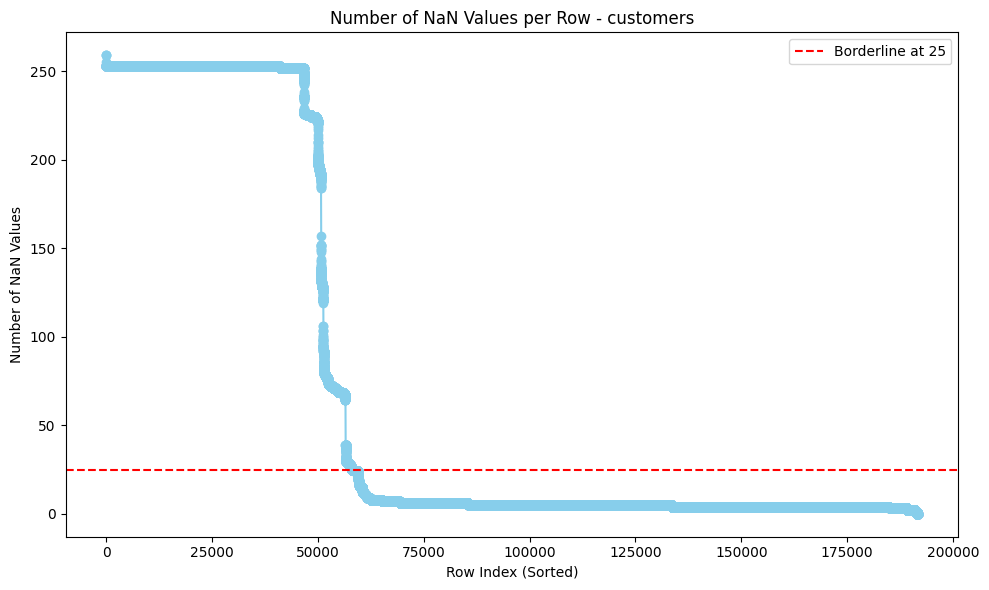

In [423]:
# Let's plot the ammount of NaN values for each row in the customers dataset.
plot_nan_count_per_row(customers, red_line_value=25, title = "customers")

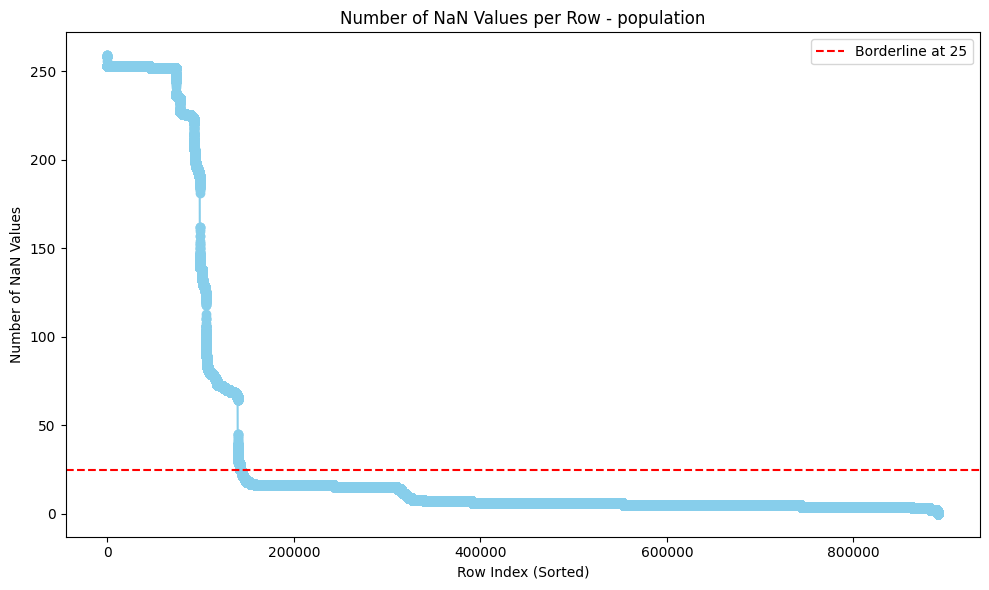

In [424]:
# Let's plot the ammount of NaN values for each row in the population dataset.
plot_nan_count_per_row(population, red_line_value=25)

The plots above reveal that there are **numerous outlier rows** with an exceptionally high number of NaN values, some reaching up to 260 missing values in a single row. A common pattern is evident across both dataframes, forming several "elbows" in the NaN count distribution, with one distinct elbow around the value 25.
To avoid distorting the analysis with these incomplete rows, we will drop all rows with more than 25 NaN values from both datasets. For the remaining missing values, we will apply imputation during the preprocessing phase.
While this step involves dropping a moderate portion of the data, these rows were predominantly **sparse** and contributed very little to the overall analysis. Removing them helps improve data quality without significantly impacting the integrity of the dataset.

Another common data issue is the presence of **duplicate rows** in the dataset. Let’s examine our datasets to identify and address any duplications.

In [425]:
# Duplicate row finding
duplicates_population = population.duplicated().sum()
print(f"Duplicate rows found for population dataset : {duplicates_population}")

duplicates_customers = customers.duplicated().sum()
print(f"Duplicate rows found for customers dataset : {duplicates_customers}")

Duplicate rows found for population dataset : 0
Duplicate rows found for customers dataset : 0


Fortunately, **no duplicate rows** were found in any of the datasets, so we can safely eliminate this issue from our concerns.<br>
Next, let’s delve into the **data types** within the datasets, as this is often where the most common and challenging issues arise.

In [426]:
data_types_population = population.dtypes.value_counts()
print("Count of columns by data type for population:")
print(data_types_population)

Count of columns by data type for population:
float32     267
int8         91
int32         1
category      1
category      1
category      1
category      1
category      1
int16         1
category      1
Name: count, dtype: int64


In [427]:
data_types_customers = customers.dtypes.value_counts()
print("Count of columns by data type for customers:")
print(data_types_customers)

Count of columns by data type for customers:
float32     267
int8         92
int32         1
category      1
category      1
category      1
category      1
category      1
int16         1
category      1
category      1
category      1
Name: count, dtype: int64


The memory reduction function has altered the data types slightly, but we can still observe that the two dataframes are not identical. Notably, the customers dataset contains more columns than the population dataset. Let’s identify which columns are exclusive to the customers dataset.

In [428]:
compare_dataframe_cols(population, customers)

Columns not common to both DataFrames: ['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']


The three columns identified above are the key differences between the datasets. To ensure both datasets are as **comparable as possible** for the segmentation analysis, these columns should be removed.<br>
Additionally, when examining the **data types**, it is important to closely inspect the **"category"** columns, as these are likely to present various preprocessing challenges or inconsistencies that need to be addressed.

In [429]:
# Let's inspect the categorical columns of customers dataset
objects_customers = customers.select_dtypes(include=['category'])
objects_customers

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER
...,...,...,...,...,...,...,...,...
191647,1C,1,14,D19_BANKEN_REST,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
191648,5B,5,32,D19_UNBEKANNT,1997-03-06 00:00:00,W,COSMETIC,SINGLE_BUYER
191649,4D,4,24,D19_TECHNIK,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
191650,4C,4,24,D19_BANKEN_REST,1992-02-10 00:00:00,W,FOOD,SINGLE_BUYER


In [430]:
# Let's inspect the categorical columns of population dataset
objects_population = population.select_dtypes(include=['category'])
objects_population

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7,41,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4,24,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W


Some of the **"category" columns** appear to be more suited as **numerical columns** possibly with some categorical variables mixed into them. To ensure the data is properly prepared for analysis, we will inspect these columns closely and make necessary adjustments. Let’s evaluate and fix them one by one.

In [431]:
print_unique_values(population, "CAMEO_DEUG_2015")
print(population["CAMEO_DEUG_2015"].value_counts())

Unique values in column 'CAMEO_DEUG_2015':
[NaN, '8', '4', '2', '6', ..., '9', '5', '7', '3', 'X']
Length: 11
Categories (10, object): ['1', '2', '3', '4', ..., '7', '8', '9', 'X']
CAMEO_DEUG_2015
8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
X       373
Name: count, dtype: int64


The column **"CAMEO_DEUG_2015"** contains mixed values — **integers** and the letter **"X"**. Based on an educated guess, it is likely that "X" indicates a missing or unrecorded value.<br>
To address this, we will **convert all occurrences of "X" to NaN**. Since "X" represents only a small fraction of the column, this adjustment will not warrant dropping the entire column due to missing value thresholds.<br>
It is also worth noting that in the original raw data, this column included float values, but our memory reduction function converted these to integers.<br>

In [432]:
print_unique_values(population, "OST_WEST_KZ")

Unique values in column 'OST_WEST_KZ':
[NaN, 'W', 'O']
Categories (2, object): ['O', 'W']


Column "OST_WEST_KZ" contains just two values, therefore we should binarize it.

In [433]:
print_unique_values(population, "D19_LETZTER_KAUF_BRANCHE")

Unique values in column 'D19_LETZTER_KAUF_BRANCHE':
[NaN, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK', ..., 'D19_BIO_OEKO', 'D19_WEIN_FEINKOST', 'D19_GARTEN', 'D19_BILDUNG', 'D19_BANKEN_LOKAL']
Length: 36
Categories (35, object): ['D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', ..., 'D19_VERSAND_REST', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST']


The column **"D19_LETZTER_KAUF_BRANCHE"** is a classic **categorical** column with a large number of unique categories. If one-hot encoding were applied, it would result in an **additional 36 columns**, significantly increasing the dimensionality of the dataset. To avoid this, it will be dropped.

In [434]:
print_unique_values(population, "CAMEO_INTL_2015")
print(population["CAMEO_INTL_2015"].value_counts())

Unique values in column 'CAMEO_INTL_2015':
[NaN, '51', '24', '12', '43', ..., '35', '45', '44', '32', 'XX']
Length: 23
Categories (22, object): ['12', '13', '14', '15', ..., '52', '54', '55', 'XX']
CAMEO_INTL_2015
51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
XX       373
Name: count, dtype: int64


Column **"CAMEO_INTL_2015"** has similar mixed datatype problems as column "CAMEO_DEUG_2015", we will apply same solution here.

In [435]:
print_unique_values(population, "CAMEO_DEU_2015")

Unique values in column 'CAMEO_DEU_2015':
[NaN, '8A', '4C', '2A', '6B', ..., '3B', '6F', '5F', '1C', 'XX']
Length: 46
Categories (45, object): ['1A', '1B', '1C', '1D', ..., '9C', '9D', '9E', 'XX']


The column **"CAMEO_DEU_2015"** is a categorical column that, if one-hot encoded directly, would result in a large number of additional features. Upon closer inspection, it appears to combine two distinct pieces of information: a number and a letter.
To handle this efficiently, we will split the column into two separate columns: A numerical column for the number and a categorical column for the letter, which will then be one-hot encoded. Plus there are NaNs present again as both "X" and "XX".
This approach will preserve the information while reducing the overall number of new columns, improving the dataset's dimensionality and maintainability.

In [436]:
print_unique_values(population, "EINGEFUEGT_AM")

Unique values in column 'EINGEFUEGT_AM':
[NaN, '1992-02-10 00:00:00', '1992-02-12 00:00:00', '1997-04-21 00:00:00', '2005-12-30 00:00:00', ..., '2013-05-03 00:00:00', '2000-03-09 00:00:00', '2010-12-02 00:00:00', '2005-03-19 00:00:00', '2011-11-18 00:00:00']
Length: 5163
Categories (5162, object): ['1991-06-17 00:00:00', '1991-08-30 00:00:00', '1992-02-10 00:00:00', '1992-02-12 00:00:00', ..., '2016-04-14 00:00:00', '2016-04-20 00:00:00', '2016-05-02 00:00:00', '2016-05-09 00:00:00']


Column **"EINGEFUEGT_AM"** is a timestamp column and contains too many values to be usable as a category column. Lets recount it as an ammount of days from the timestamp till now. That will give us a single int column.

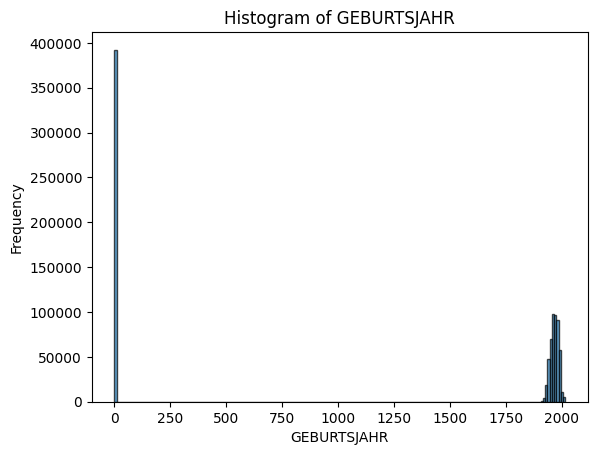

In [437]:
# Let's plot a histogram of column "GEBURTSJAHR"
plot_column_histogram(population, "GEBURTSJAHR", bins=200, title=None, xlabel=None, ylabel="Frequency")

Another finding from our EDA is the column **"GEBURTSJAHR"**, where nearly **50% of the values are missing**, with the missing values cleverly masked as zeros. Since a value of zero is not meaningful in this context, these entries should be treated as NaN.<br>
Due to the excessive amount of missing values, this column will be dropped from the dataset.

We should also check our dataframe for multicollinearity between the features. We don't want any dataset features to be perfectly correlated together.

In [438]:
high_corr_pairs = find_highly_correlated_pairs(customers, threshold=0.98)
print(high_corr_pairs)

[('ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', np.float64(0.990112182424038)), ('KBA13_FAB_SONSTIGE', 'KBA13_HERST_SONST', np.float64(1.0)), ('LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', np.float64(0.9820956724005007)), ('LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB', np.float64(0.9882140005794926)), ('LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', np.float64(0.9938110795868202))]


We observed several pairs of columns with near-perfect **multicollinearity**. Such highly correlated columns (correlation > **0.98**) can distort our analysis and introduce redundancy. To address this, we will identify these pairs and drop one column from each pair. This approach will not only improve the overall condition of our dataset but also slightly reduce its dimensionality, making it more manageable and efficient for analysis.

In [439]:
cols_drop_multicollinearity = ['ANZ_STATISTISCHE_HAUSHALTE', 'KBA13_HERST_SONST', 'LP_FAMILIE_GROB','LP_LEBENSPHASE_GROB']

Last but not least we should check the distribution of the label class in the dataset we will train our models on later, to see what kind of class balance are we dealing with.

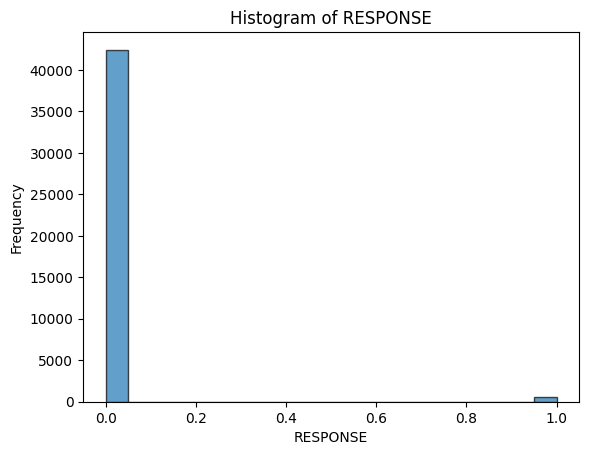

In [440]:
# Load training dataset with RESPONSE label
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)

plot_column_histogram(mailout_train, "RESPONSE", bins=20, title=None, xlabel=None, ylabel="Frequency")

It appears that there is a very severe class imbalance in the dataset. There is only small portion of actual customers compared to the non-customers. 

**Summary of EDA**

From our observations during the EDA, several columns have been identified as requiring special attention due to unique issues or characteristics.

- **Columns  'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP'**<br>
Those columns contain higher ammount of NaN values than the other columns (over 30%) and should be dropped.

- **Columns 'ANZ_STATISTISCHE_HAUSHALTE', 'KBA13_HERST_SONST', 'LP_FAMILIE_GROB','LP_LEBENSPHASE_GROB'**<br>
These columns are highly multicorrelated with the rest of the dataset (over 0.98 pearson) and should be dropped.

- **Columns "CAMEO_DEUG_2015" and "CAMEO_INTL_2015"**<br>
These columns have categorical instance of NaN value present in them as "X"/"XX", which has to be converted to NaN.

- **Column "OST_WEST_KZ"**<br>
Should be binarized, as it only contains two unique values.

- **Column "D19_LETZTER_KAUF_BRANCHE"**<br>
This column will be dropped due to high cardinality and impact on dataset dimension if one hot encoded.

- **Column "CAMEO_DEU_2015"**<br>
Will be split into an int and a categorical column, which will be one hot encoded.

- **Column "EINGEFUEGT_AM"**<br>
Which contains timestamps, will be dropped, because majority of data is missing.

- **Column "LNR"**<br>
This is the "ID" of this dataset, it will be dropped since it is not any helpful to us.




**Preprocessing**

Based on findings from our EDA a preprocessing function will be made for our dataset to allow further analysis.<br>
In addition to dropping columns and rows on several conditions and fixing encoding problems, we also  have to :<br>
- encode categorical columns (using one-hot-encoding)
- impute remaining NaNs 
- scale the dataset, for following PCA (using standardscaler)

We don't need to scale the dataset for the training, because we will use scale/insensitive tree models.

In [441]:
def preprocessing(df:pd.DataFrame, mode:str="segment")->Tuple[pd.DataFrame, StandardScaler, pd.DataFrame]:
    """main preprocessing function"""

    # 1 Drop non-common columns
    columns_to_drop = ['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    # 2 Drop the ID column (LNR) which does not contribute to anything in our analysis
    id_column = ['LNR']
    df = df.drop(columns=id_column)

    # 3 Drop the high cardinality categorical column
    cardinality_column = ["D19_LETZTER_KAUF_BRANCHE"]
    df = df.drop(columns=cardinality_column)
    
    # 4 Drop High NaN columns
    nan_columns  = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP', 'GEBURTSJAHR']
    df = df.drop(columns=nan_columns)

    # 5 Impute X/XX with NaNs for appropriate columns
    mixed_cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015", "CAMEO_DEU_2015"]
    df = replace_x_with_nan(df, mixed_cols)
    
    # 6 Drop high NaN rows
    df = df[df.isna().sum(axis=1) <= 25].reset_index(drop=True)
    
    # 7 Drop Multicorrelated columns
    multicollinearity_columns = ['ANZ_STATISTISCHE_HAUSHALTE', 'KBA13_HERST_SONST', 'LP_FAMILIE_GROB','LP_LEBENSPHASE_GROB']
    df = df.drop(columns=multicollinearity_columns)
    
    # 8 Binarize column with 2 unique values
    df["OST_WEST_KZ"] = (df["OST_WEST_KZ"] == 'W').astype(int)
    
    # 9 Recount the timestamp column as a sum of days
    df['EINGEFUEGT_AM'] = (datetime.now() - pd.to_datetime(df['EINGEFUEGT_AM'])).dt.days

    # 10 Split the combined column into two
    df = split_column(df, "CAMEO_DEU_2015", "CAMEO_DEU_2015_num", "CAMEO_DEU_2015_cat")
    df = df.drop(columns='CAMEO_DEU_2015')

    # 11 Encode categorical columns
    columns_to_encode = ["CAMEO_DEU_2015_cat"]
    df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False)
    df = df.apply(lambda col: col.astype('Int64') if col.dropna().isin([True, False]).all() else col)

    category2_cols = ["CAMEO_DEUG_2015","CAMEO_INTL_2015"]		
    df[category2_cols] = df[category2_cols].astype('Int64')

    comparison_df = df.copy()

    numeric_cols = df.select_dtypes(include=['float64','float32', 'int64', 'int32', 'int16', 'int8']).columns
    categorical_cols = df.select_dtypes(include=['category']).columns

    # 12 Impute numeric columns
    num_imputer = SimpleImputer(strategy='median')
    df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])
    
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    bool_cols = df.select_dtypes(include=['bool']).columns

    if mode == "segment":
        # 13 Scale dataset
        scaler = StandardScaler()
        df[num_cols] = scaler.fit_transform(df[num_cols])
        df = pd.concat([df[num_cols], df[bool_cols]], axis=1)

    elif mode == "train":
        scaler = None

    return df, scaler, comparison_df

In [442]:
# Apply the preprocessing function 
prep_population, scaler_population, compare_population = preprocessing(population)
prep_customers, scaler_customers, compare_customers = preprocessing(customers)

In [443]:
# Check the cleaned dataframe size and reduce it if possible
prep_customers = reduce_memory_usage(prep_customers)
prep_population = reduce_memory_usage(prep_population)

Iteration 1: Initial memory usage: 369.83 MB
Iteration 1: Optimized memory usage: 184.92 MB
Reduced by 50.0%
Iteration 2: Initial memory usage: 184.92 MB
Iteration 2: Optimized memory usage: 184.92 MB
Reduced by 0.0%
Iteration 1: Initial memory usage: 2055.79 MB
Iteration 1: Optimized memory usage: 1027.90 MB
Reduced by 50.0%
Iteration 2: Initial memory usage: 1027.90 MB
Iteration 2: Optimized memory usage: 1027.90 MB
Reduced by 0.0%


In [444]:
print("population")
print(f"Shape raw : {population.shape}")
print(f"Shape preprocessed : {prep_population.shape}")

print("customers")
print(f"Shape raw : {customers.shape}")
print(f"Shape preprocessed : {prep_customers.shape}")

population
Shape raw : (891221, 366)
Shape preprocessed : (750577, 359)
customers
Shape raw : (191652, 369)
Shape preprocessed : (135026, 359)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the <br>company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

Now that both datasets are cleaned and comparable, we can finally begin the customer segmentation analysis.

Given the large number of columns in both datasets, direct analysis would be challenging. To simplify and streamline the process, the first step in our segmentation efforts will be to reduce the dimensionality of the dataset into fewer categories using Principal Component Analysis (PCA).

Afterward, we will apply the KMeans algorithm to cluster the data. This will enable us to identify regions in the data where customers are either overrepresented or underrepresented, providing valuable insights for segmentation.

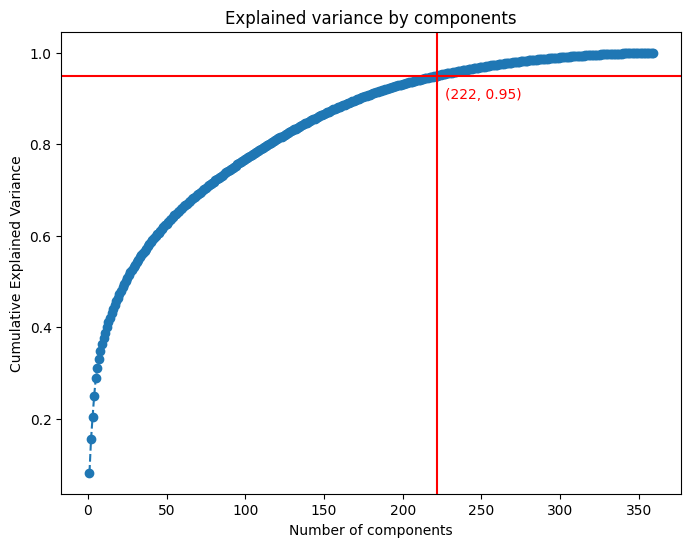

In [445]:
# Fit PCA to population
pca = PCA()
pca.fit(prep_population)

cumulative_variance = pca.explained_variance_ratio_.cumsum()
threshold = 0.95
components_at_threshold = np.argmax(cumulative_variance >= threshold) + 1

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=threshold, color='red', linestyle='-')
plt.axvline(x=components_at_threshold, color='red', linestyle='-')
plt.scatter(components_at_threshold, threshold, color='red')  # Mark the intersection point
plt.text(components_at_threshold + 5, threshold - 0.05, f'({components_at_threshold}, {threshold:.2f})', color='red')

plt.show()

We fitted the **PCA** to the population dataset, reducing the number of columns **from 359 to 222** while retaining **95% of the variance**. This represents a favorable trade-off, significantly simplifying the dataset without sacrificing much information.

In [446]:
# Re-fit the PCA with our desired ammount of PCA components (222)
pca = PCA(n_components = 222)
pca.fit(prep_population)
scaled_pca = pca.transform(prep_population)

With the datasets reduced, we can proceed to clustering using **KMeans**, specifically the efficient **k-means++ algorithm**. However, an important decision is determining the **optimal number of clusters**.

This step requires careful tuning: too few clusters may fail to reveal meaningful insights, while too many clusters could become computationally not feasible.

As an initial step in this process, we will generate an **elbow plot** of the **within-cluster sum of squares (WCSS)** to visually identify the point where adding more clusters offers diminishing returns.

In [447]:
# Determine optimum number of KMeans clusters using WCSS elbow plot
within_cluster_sum = []
for cluster_count in range(1, 15):
    kmeans_model = KMeans(n_clusters=cluster_count, init='k-means++', random_state=42)
    kmeans_model.fit(scaled_pca)
    within_cluster_sum.append(kmeans_model.inertia_)

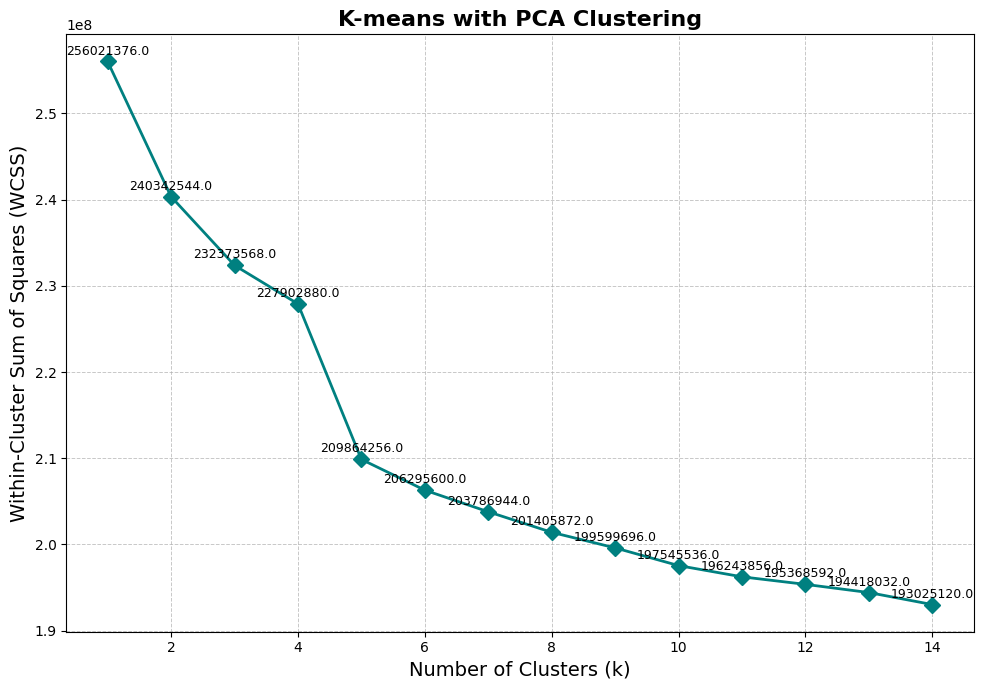

In [448]:
plot_kmeans_with_pca(within_cluster_sum, max_clusters=14, title='K-means with PCA Clustering')

In the WCSS plot, we observe a pattern resembling the desired elbow at 5 clusters. However, this number feels slightly low for the actual amount of clustering we might need.

From the experiments with the data it turned out, that at 5 clusters selected, there are no visible differencies to be seen between the datasets, we need more clusters.

To gain additional insights, we will examine the Silhouette score plot, which can provide a more nuanced perspective on the quality of clustering.

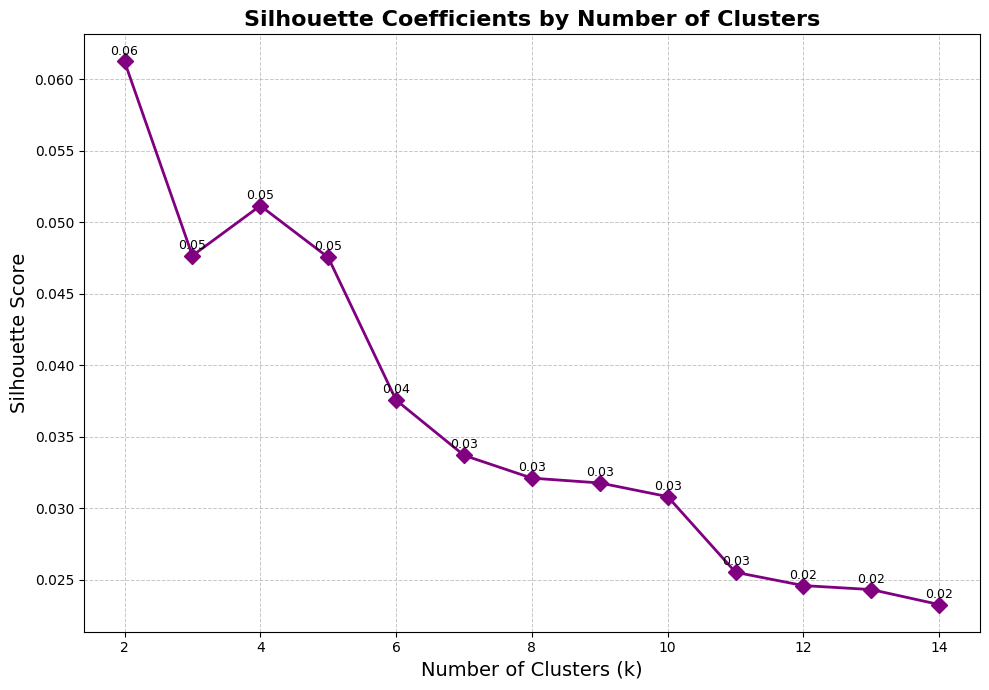

In [449]:
plot_silhouette_scores(scaled_pca, max_clusters=14, sample_size=20000, title='Silhouette Coefficients by Number of Clusters')

In the Silhouette score plot, we observe a distinct spike at k=5 clusters, but this still seems too low for our needs. Upon further experimentation, we found that using 5 clusters does not provide any meaningful advantage in the analysis, as no significant differences were identified.

Another reasonable choice is k=10, which corresponds to the last point before the curve starts to drop again. Based on this, we will proceed with k=10 clusters for our segmentation analysis.

In [450]:
# Set final PCA and KMeans parameters
pca_components = 222
kmeans_clusters = 10

In [451]:
# Create cluster pipeline
cluster_pipeline = Pipeline([
    ('reduce', PCA(n_components = pca_components)),
    ('cluster', KMeans(n_clusters = kmeans_clusters, init = 'k-means++', random_state=42))
])

In [452]:
# Fit the pipeline
cluster_pipeline.fit(prep_population)

# Predict cluster labels for the population and customers dataframes
df_population = pd.DataFrame(cluster_pipeline.predict(prep_population), columns = ['Cluster'])
df_customers = pd.DataFrame(cluster_pipeline.predict(prep_customers), columns = ['Cluster'])

# Count the occurrences of each cluster in the datasets and sort by index
population_clusters = df_population['Cluster'].value_counts().sort_index()
customer_clusters = df_customers['Cluster'].value_counts().sort_index()

# Concatenate the population and customer cluster counts by columns for comparison
clusters = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
clusters.columns = ['cluster', 'population_count', 'customers_count']
clusters['cluster']+=1

# Calculate the % share of each cluster in the total dataset
clusters['population_share'] = clusters['population_count']/clusters['population_count'].sum()*100
clusters['customers_share'] = clusters['customers_count']/clusters['customers_count'].sum()*100
clusters['diff_share'] = clusters['customers_share'] - clusters['population_share']

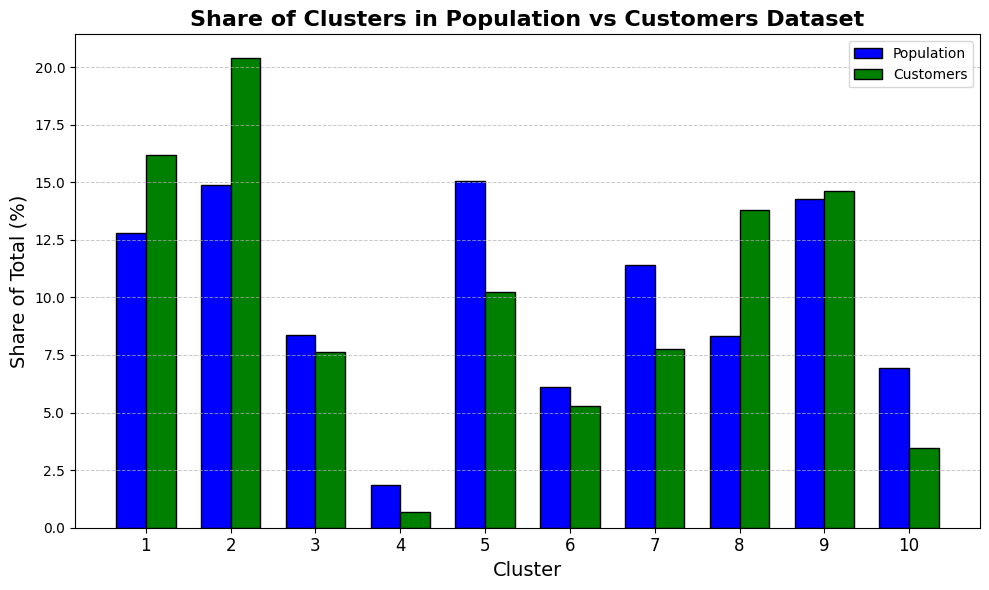

In [453]:
plot_cluster_shares(clusters, kmeans_clusters)

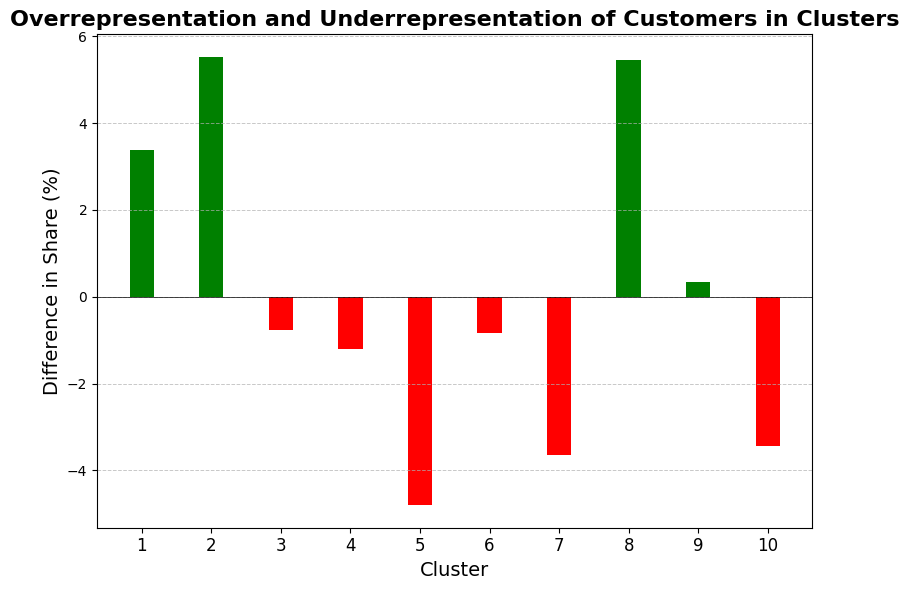

In [454]:
plot_cluster_difference(clusters, kmeans_clusters)

The plots above present the preliminary results of our segmentation analysis.

With the data reduced to 222 PCA components and segmented into 10 clusters, we observe significant patterns in customer representation:

- Overrepresentation: Clusters 2 and 8 show a higher proportion of customers compared to the general population.
- Underrepresentation: Clusters 5 and 7 exhibit a lower proportion of customers relative to the population.

These clusters likely capture features that differentiate customer behavior from non-customer behavior. Next, let’s delve deeper into these clusters to understand how these patterns emerge.

In [455]:
# Now it is time to restore our dataframes into original raw state by inverting the preprocessing pipeline, to see the actual differences between them in the important clusters
column_names = list(prep_population.columns)
cluster_centers = get_clusters_attributes(cluster_pipeline, scaler_population, column_names)
cluster_centers.head(10)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_DEU_2015_num,CAMEO_DEU_2015_cat_A,CAMEO_DEU_2015_cat_B,CAMEO_DEU_2015_cat_C,CAMEO_DEU_2015_cat_D,CAMEO_DEU_2015_cat_E,CAMEO_DEU_2015_cat_F
0,0.317395,4.595053,7.475163,11.152506,13.288713,0.058450,0.015708,1.316923,0.003444,3.538351,...,3.471426,1.547432,3.516773,7.253080,0.278364,0.239967,0.209750,0.180339,0.072608,0.016495
1,0.317973,3.194076,8.752363,10.726355,2.281559,0.008192,0.043787,1.625189,0.003538,2.556384,...,2.759729,1.472661,3.528037,3.867381,0.215728,0.208976,0.294437,0.225463,0.036112,0.013687
2,-0.736970,3.345093,14.913107,16.613234,11.195700,0.037406,0.360883,2.099127,0.001568,3.516706,...,3.898530,1.573155,2.233356,6.947361,0.308089,0.276108,0.214472,0.147356,0.042619,0.010679
3,-0.446556,6.401438,6.769760,12.974624,25.877165,0.143279,0.035697,1.208583,0.004142,3.549555,...,3.760229,1.545642,3.033029,7.388905,0.106055,0.235821,0.238785,0.228634,0.155834,0.016332
4,-0.973813,6.628487,10.862427,16.077000,6.066512,0.015167,0.142478,1.413607,0.001251,2.842882,...,3.997563,1.569081,2.036170,5.221968,0.272074,0.259618,0.272518,0.153837,0.028264,0.009296
5,-0.078029,3.533047,10.925324,13.117263,2.684237,0.006180,0.122163,1.833783,0.002913,3.661308,...,3.222741,1.505076,3.028013,4.710963,0.155142,0.251342,0.280522,0.231067,0.053413,0.012374
6,-0.832157,6.392988,10.146632,15.312527,18.222422,0.081240,0.072127,1.260103,0.002890,3.694010,...,4.262932,1.492005,2.271769,7.946845,0.266687,0.311373,0.208412,0.184211,0.019423,0.006794
7,-0.007173,4.016400,9.747564,12.535756,7.018745,0.114186,0.093200,1.634455,0.016741,3.099119,...,3.023548,1.503909,3.088901,4.226876,0.148205,0.172974,0.184779,0.378435,0.097340,0.015577
8,-0.355444,2.488452,15.738019,14.833162,1.895401,0.007774,0.386906,2.932988,0.004810,2.602442,...,2.405468,1.512349,2.771345,3.650645,0.248006,0.202507,0.292301,0.210954,0.032860,0.010208
9,-0.189299,4.981375,9.656537,13.450182,14.972344,0.056389,0.065613,1.400817,0.002728,4.163726,...,3.882506,1.511395,2.900340,7.584147,0.209979,0.225168,0.219235,0.199686,0.119859,0.017916


Let's choose top 2 clusters with the customer overrepresentation (2 and 8) and top2 clusters with customer underrepresentation (5 and 7)

In [456]:
# Transpose the dataframe and choose desired cluster centers. Filter the dataframe by std to see only those with variation across clsuters.
compare_clusters_df = cluster_centers.T[[1,7,4,6]]
compare_clusters_df = compare_clusters_df[compare_clusters_df.std(axis=1)>2]
compare_clusters_df.columns=['customer-cluster-2','customer-cluster-8','non-customer-cluster-5', 'non-customer-cluster-7']

In [457]:
compare_clusters_df

,customer-cluster-2,customer-cluster-8,non-customer-cluster-5,non-customer-cluster-7
ALTERSKATEGORIE_FEIN,10.726355,12.535756,16.077000,15.312527
ANZ_HAUSHALTE_AKTIV,2.281559,7.018745,6.066512,18.222422
CAMEO_INTL_2015,26.237972,28.887035,33.538162,47.329754
EINGEFUEGT_AM,11561.971680,11708.632812,11589.408203,11789.041016
EINGEZOGENAM_HH_JAHR,2000.552734,2002.940430,2005.560181,2005.630981
GEMEINDETYP,31.440287,17.854870,27.653185,12.683608
KBA13_ANZAHL_PKW,721.421326,619.808716,733.655396,428.239746
LP_LEBENSPHASE_FEIN,17.866434,15.813248,10.139874,7.217451
LP_STATUS_FEIN,7.821394,5.530264,3.943370,1.836344
PRAEGENDE_JUGENDJAHRE,5.849074,7.920637,11.933331,10.826845


The DataFrame above highlights the features that are significantly influenced by a person's customer or non-customer status. These features exhibit variation across the selected clusters, making them key differentiators.

Next, we will dig deeper to explore how each feature impacts the odds of an individual being classified as a customer. This analysis will provide insights into the behaviors and attributes that distinguish customers from non-customers.

In [458]:
# Calculate means for the columns identified during segmentataion analysis across the original dataframes.
culster_columns = compare_clusters_df.index.tolist()
difference_df = compute_means(compare_customers, compare_population, culster_columns)
difference_df = difference_df.drop(columns='EINGEFUEGT_AM')
difference_df.head(2)

,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,CAMEO_INTL_2015,EINGEZOGENAM_HH_JAHR,GEMEINDETYP,KBA13_ANZAHL_PKW,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,PRAEGENDE_JUGENDJAHRE
0,10.237611,4.922081,29.386623,1998.742310,24.708466,665.374268,23.225466,7.174688,5.583562
1,13.630245,8.507750,35.854568,2003.420532,23.968622,616.478210,15.246905,4.672860,8.912387


In [459]:
plot_segmentation_results(difference_df)

**Customer Segmentation Analysis Results**
The results of customer segmentation analysis reveal distinct patterns in several features that differentiate customers from the general population.<br>
These insights are based on differences in mean values between the two groups.<br>

Unluckily, there are no details available to deeply understand meaning of the column names, so we are left with an educated guess.<br>

**Features with Lower Mean Values for Customers**

- 'ALTERSKATEGORIE_FEIN' - with translation is "fine age category" it is probably an ordinal category of age. If we assume that it is sorted, then it would mean that younger people are more probable to be cutomers.<br>
- 'ANZ_HAUSHALTE_AKTIV' - this one probably means the number of active members of a household. Implying that the smaller-households tend to be customers more than the larger households.<br>
- 'CAMEO_INTL_2015' - probably refers to CAMEO socio-economic scores, where lower values indicate high income persons and high values low income persons. It makes sense that low income persons will not be customers that often.<br>
- 'PRAEGENDE_JUGENDJAHRE' - could possibly be a category of an historical era when the person grew up. It makes distinction of customers possible based on this category.<br>

**Features with Higher Mean Values for Customers**

- 'KBA13_ANZAHL_PKW' - could be a measure of cars owned per geographical unit where one lives. Implying that people from areas where more cars are owned should indeed be more wealthy and possibly customers.<br>
- 'LP_LEBENSPHASE_FEIN' - is probably a category descirbing a life phase of a person, based on some unknown metric. It would make sense that it is connected with overal quality of life, implying that happy people are more often likely to be customers.<br>
- 'LP_STATUS_FEIN'- category of an unknown status of a person, which tends to be almost double for customers compared to non-customers.<br>
- 'GEMEINDETYP' - should reffer to community type - likely are of living. There is only slight variation across the data and the exact meaning is unknown. <br>

**Features with Similar Mean Values but High Max values**

- 'EINGEZOGENAM_HH_JAHR' - should represent year, when household moved in. Showing that the people moved in later than in 2023 tend to be customers not as ofther as those who moved in in previous years.<br>

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

We have finaly reached the modeling part, it's time to use the remaining parts of the whole datasets - the mailout data.<br>
Let's outline the approach first:
- We will begin with loding the train and test mailout data
- We have to preprocess them the same way as we did with the segmentation data
- Then we will train a classifer model on the mailout data with goal of predicting the RESPONSE target variable.
- Finally we will compare the model insights with our cluster analysis results.

**Metrics**<br>

We will use two types of metrics for this task: <br>

1. Precision-Recall curves score.<br>
   Ideal for our use case, because we are mostly interested in ability to classify the minority label.<br>
   We will be able to retrieve this score when cross-validating during the training.<br>

2. KDE plots of predicted probablilites, compared on train and test set.<br>
   Since we have no ground truth for the test set, the best we can do is compare performance on both datasets.<br>
   While this is a rather visual technique, it can show the overal pattern in predicted probability distributions, assuming that they should be similar across both datasets.


In [460]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)

In [461]:
mailout_train.shape

(42962, 367)

The train dataset is a lot smaller version of both customers and population datasets with known labels.

In [462]:
mailout_train.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [463]:
# Apply the preprocessing function we prepared for the segmentation analysis, without scaling because we will use tree models
prep_train_cleaned, _ ,_ = preprocessing(mailout_train, "train")
prep_train_cleaned.head(5)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_DEU_2015_num,CAMEO_DEU_2015_cat_A,CAMEO_DEU_2015_cat_B,CAMEO_DEU_2015_cat_C,CAMEO_DEU_2015_cat_D,CAMEO_DEU_2015_cat_E,CAMEO_DEU_2015_cat_F
0,2.0,1.0,8.0,8.0,15.0,0.0,0.0,1.0,0.0,3.0,...,0.0,2.0,4.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,4.0,13.0,13.0,1.0,0.0,0.0,2.0,0.0,2.0,...,0.0,2.0,3.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,9.0,7.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,1.0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.0,1.0,6.0,6.0,4.0,0.0,0.0,2.0,0.0,4.0,...,0.0,2.0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.0,1.0,9.0,9.0,53.0,0.0,0.0,1.0,0.0,3.0,...,0.0,1.0,3.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0


In [464]:
# Split the data into features and response
X_train = prep_train_cleaned.drop(['RESPONSE'], axis=1)
y_train = prep_train_cleaned['RESPONSE']

Let's remind us how serious problem do we have with **class imbalance** in the train dataset.

In [465]:
print_class_counts(y_train)

Number of 0s: 33761
Number of 1s: 424
Percentage of 1s: 1.24%


That's quite bad situation, there is only arround 1% of positive label in the dataset. How will it impact our efforts? We can try to mitigate it by using stratified kfold cross validation during training, but will it be enough?

We will use 5folds crossvalidated and stratified XGBoost classifier trained by hyperopt search space. That is a very versatile tool to ahndle most of the classification tasks.

100%|██████████| 5/5 [00:53<00:00, 10.70s/trial, best loss: -0.04300875057315925]
Precision-Recall AUC (train) = 0.47
Precision-Recall AUC (validation) = 0.04


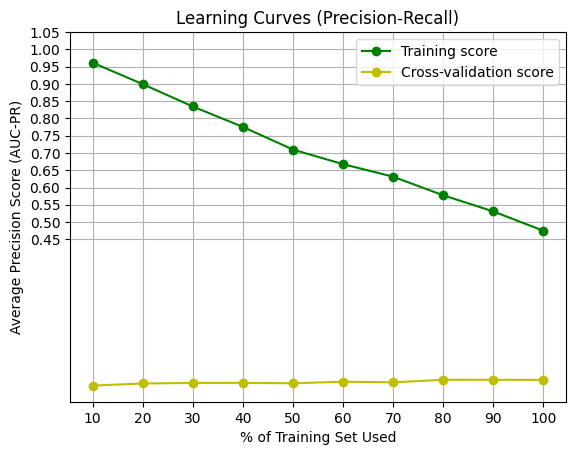

In [466]:
base_model_xgb = train_and_evaluate_model_prc(X_train, y_train, num_trainings=10, max_evals=5)

Well, that's not the result we hoped for. The model is not able to classify the positive labels even on training set, let alone the cross validation set. Let's see how probability distribution comparison works for this model.

In [467]:
# Load the test data
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)
# Preprocess the test data
X_test, _ ,_ = preprocessing(mailout_test, "train")

In [468]:
# Predict probabilities on the training set
y_train_proba = base_model_xgb.predict_proba(X_train)[:, 1]

# Predict probabilities on the test set
y_test_proba = base_model_xgb.predict_proba(X_test)[:, 1]

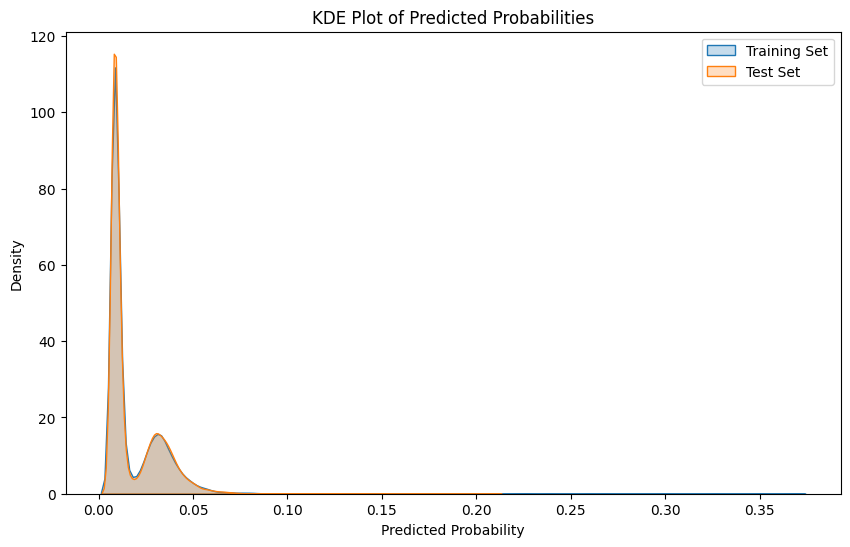

In [469]:
plot_predicted_probabilities(y_train_proba, y_test_proba)

From the KDE plot, it is evident that the classifier **never predicts the minority class**, as probabilities for this class rarely exceed 0.5.<br>
The primary issue here is the class imbalance in the dataset. To address this, we have two main options: oversampling or undersampling.<br>
Based on my past experience, oversampling often leads to suboptimal results, so we will opt for the undersampling approach to tackle this issue effectively.<br>

Let's try again, this time with undersampling the train dataset.

In [470]:
# Perform undersampling of the Majority class
prep_train_undersampled = drop_random_rows(prep_train_cleaned, "RESPONSE", 119, 0, 32900)

# Split the data into features and response
X_train = prep_train_undersampled.drop(['RESPONSE'], axis=1)
y_train = prep_train_undersampled['RESPONSE']

print_class_counts(y_train)

Number of 0s: 861
Number of 1s: 424
Percentage of 1s: 33.00%


This time we have significantly more items on the minority side, let's train the model again.

100%|██████████| 15/15 [00:14<00:00,  1.04trial/s, best loss: -0.6104927996084994]
Precision-Recall AUC (train) = 0.92
Precision-Recall AUC (validation) = 0.61


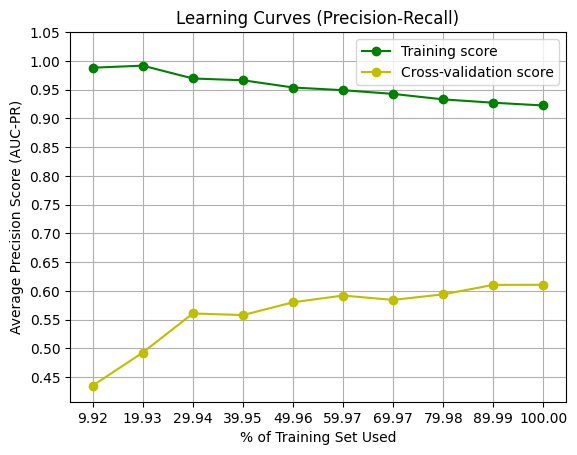

In [471]:
undersampled_model_xgb = train_and_evaluate_model_prc(X_train, y_train, num_trainings=10, max_evals=15)

In [472]:
# Predict probabilities on the training set
y_train_proba = undersampled_model_xgb.predict_proba(X_train)[:, 1]

# Predict probabilities on the test set
y_test_proba = undersampled_model_xgb.predict_proba(X_test)[:, 1]

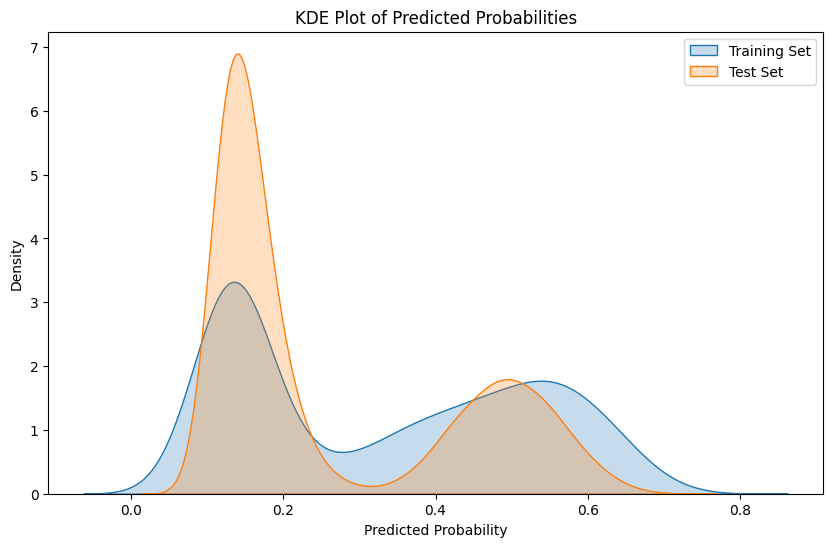

In [473]:
plot_predicted_probabilities(y_train_proba, y_test_proba)

That is a much better result! We have reached P-R curve score 0.62 which however is slightly better than a random guess. The classifier now predicts the minority class as well, and the patterns of predicted probabilities are roughly similar between the training and test sets.<br>
However, it still feels like we are missing out on much of the dataset's potential, as the undersampling approach uses only a small fraction of the available data.<br>
To improve the solution, we could adopt a bootstrap aggregation (bagging) approach. This would involve repeatedly undersampling the dataset, training multiple classifiers, and then averaging their predictions.<br>
This method allows us to leverage the entire dataset while maintaining the benefits of undersampling.<br>

Processing seed: 42 (Iteration 1)
100%|██████████| 10/10 [00:09<00:00,  1.07trial/s, best loss: -0.6078289694723743]
Precision-Recall AUC (train) = 0.96
Precision-Recall AUC (validation) = 0.61


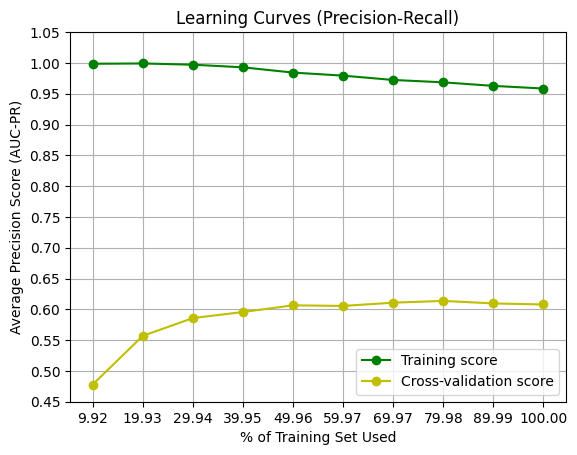

Processing seed: 60 (Iteration 2)
100%|██████████| 10/10 [00:09<00:00,  1.08trial/s, best loss: -0.5872484292502497]
Precision-Recall AUC (train) = 0.85
Precision-Recall AUC (validation) = 0.59


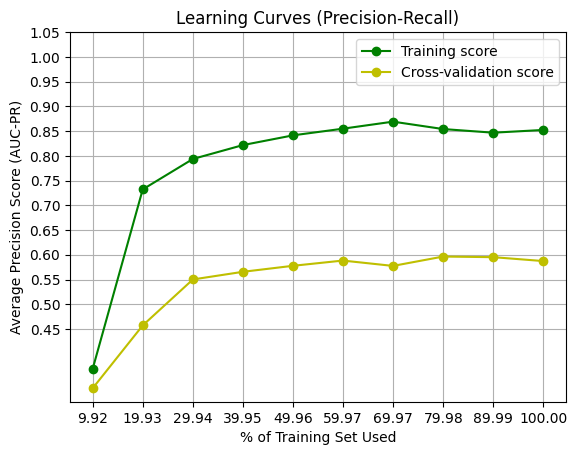

Processing seed: 111 (Iteration 3)
100%|██████████| 10/10 [00:08<00:00,  1.12trial/s, best loss: -0.6047370075597854]
Precision-Recall AUC (train) = 1.00
Precision-Recall AUC (validation) = 0.60


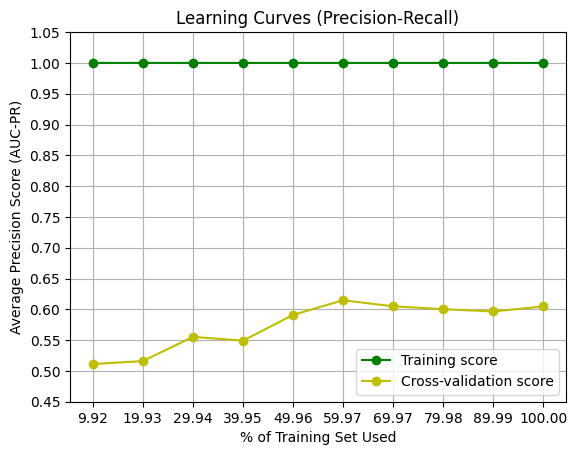

Processing seed: 119 (Iteration 4)
100%|██████████| 10/10 [00:09<00:00,  1.10trial/s, best loss: -0.6134632025532902]
Precision-Recall AUC (train) = 0.96
Precision-Recall AUC (validation) = 0.61


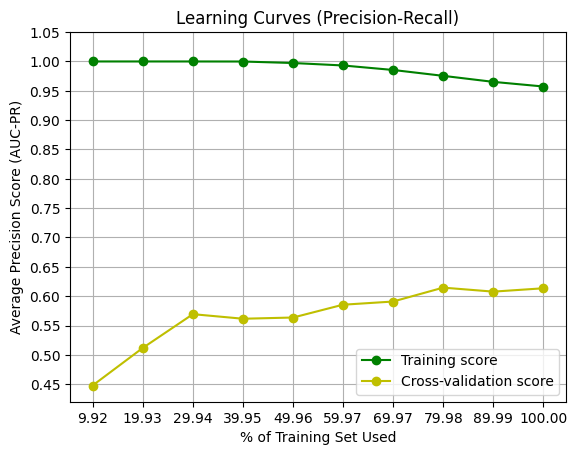

Processing seed: 301 (Iteration 5)
100%|██████████| 10/10 [00:08<00:00,  1.14trial/s, best loss: -0.585767408655587]
Precision-Recall AUC (train) = 1.00
Precision-Recall AUC (validation) = 0.59


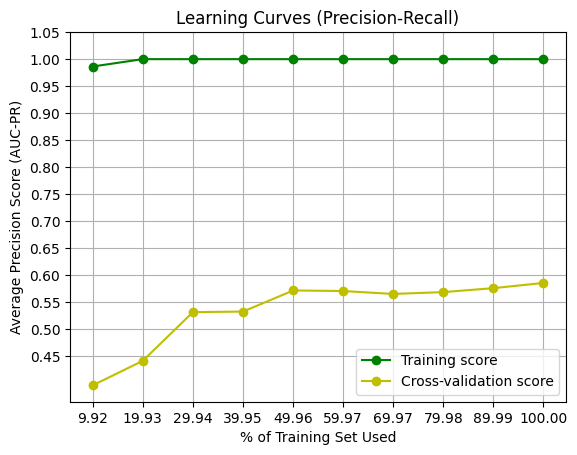

In [474]:
bagging_dict = bagging_wrapper(prep_train_cleaned, train_and_evaluate_xgb)

In [475]:
y_train_proba_average, y_test_proba_average = average_bagging_predictions(bagging_dict, X_test)

Processing model from bagging iteration 1
Processing model from bagging iteration 2
Processing model from bagging iteration 3
Processing model from bagging iteration 4
Processing model from bagging iteration 5


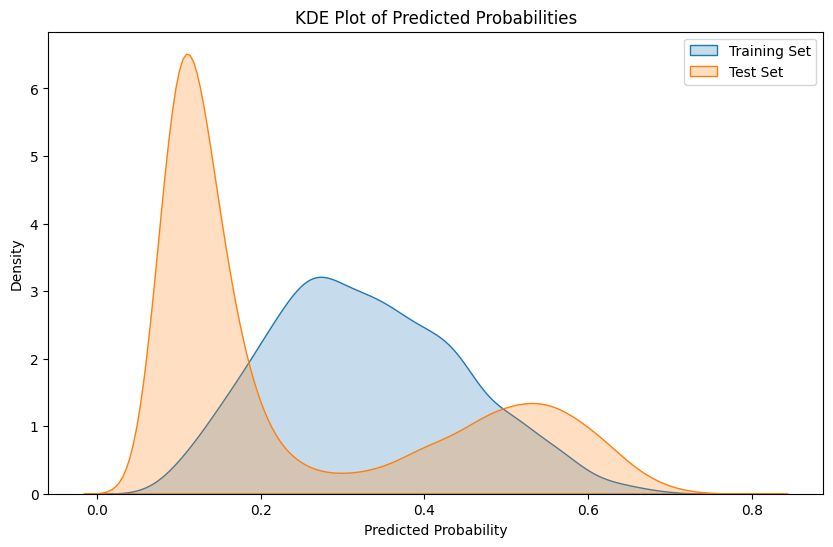

In [476]:
plot_predicted_probabilities(y_train_proba_average, y_test_proba_average)

With the average Precision Recall score for the bootstrap aggregation approach being less than for a single classifier, we will not go this way because we can't justify the extra complexity.

Let's try using another model to train a classifier.

100%|██████████| 15/15 [01:35<00:00,  6.39s/trial, best loss: -0.6240816803953185]
Precision-Recall AUC (train) = 0.99
Precision-Recall AUC (validation) = 0.62


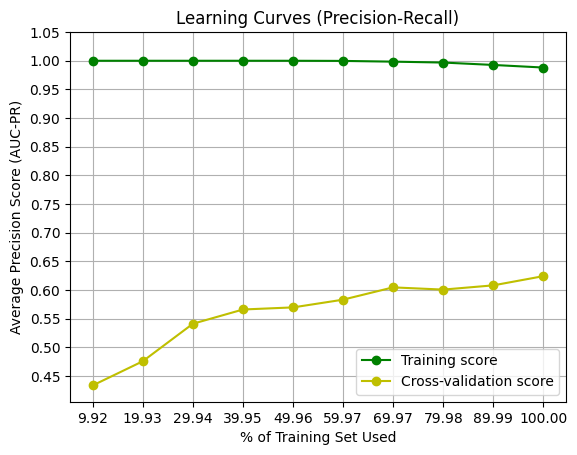

In [477]:
undersampled_model_gbc = train_and_evaluate_gb(X_train, y_train, num_trainings=10, max_evals=15)

In [478]:
y_train_proba = undersampled_model_gbc.predict_proba(X_train)[:, 1]
y_test_proba = undersampled_model_gbc.predict_proba(X_test)[:, 1]

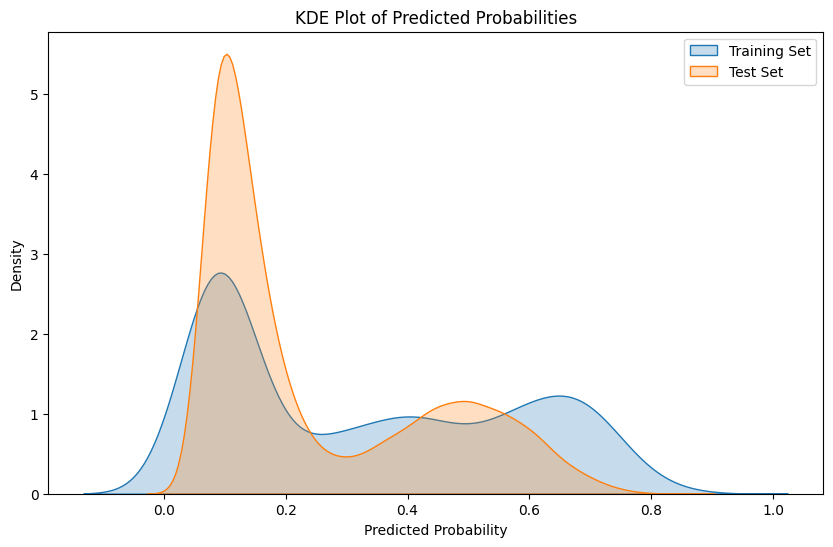

In [479]:
plot_predicted_probabilities(y_train_proba, y_test_proba)

The pefromance of Gradient Boosting Classifier is nearly indentical to XGBoost Classifier, it seems that we will not gain any improvements here by pure switching of models.

Therefore the best classifier we were able to train is the XGBoost classifier trained on the undersampled dataset. It is a rather simple model with low depth, to make sure it does not overfit too much.

In [480]:
undersampled_model_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.904536956533248), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None,
              gamma=np.float64(0.44860750854664805), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.024657068468633185), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None, nthread=-1,
              num_parallel_tree=None, ...)

Let's assess the feature importances of the final XGBoost model.<br>
We can observe that by far, the most important feature is D19_SOZIALES.<br>
Unfortunately our customer segmentation analysis did not mark it as a relevant one for distinction between customers and non-customers.<br>
Therefore our solution has lots of room for future improvement.<br>

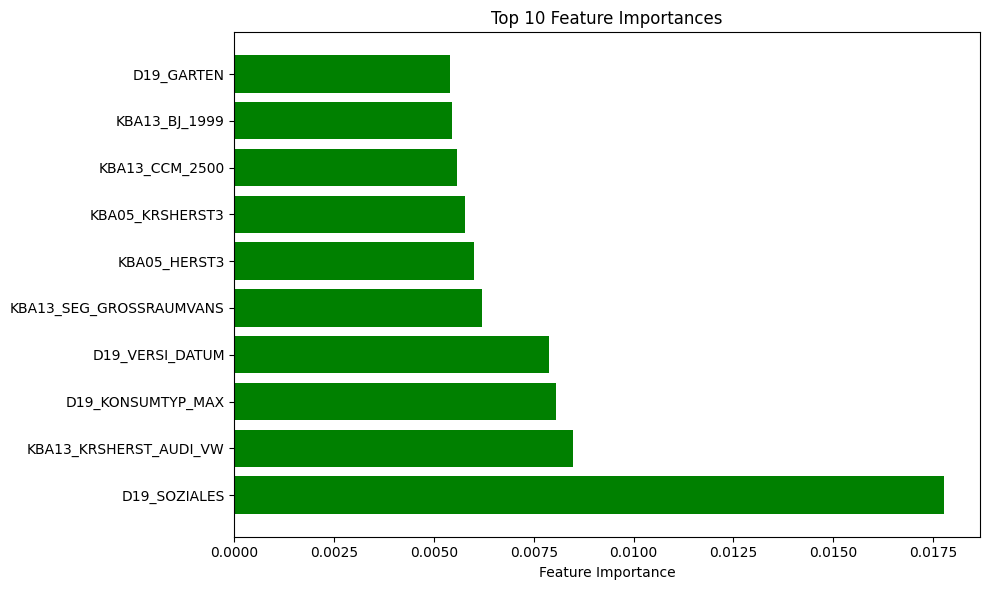

In [481]:
 plot_top_feature_importances(undersampled_model_xgb, X_train, top_n=10)

Let's observe based on what model decides to use the "D19_SOZIALES"

<Figure size 1000x600 with 0 Axes>

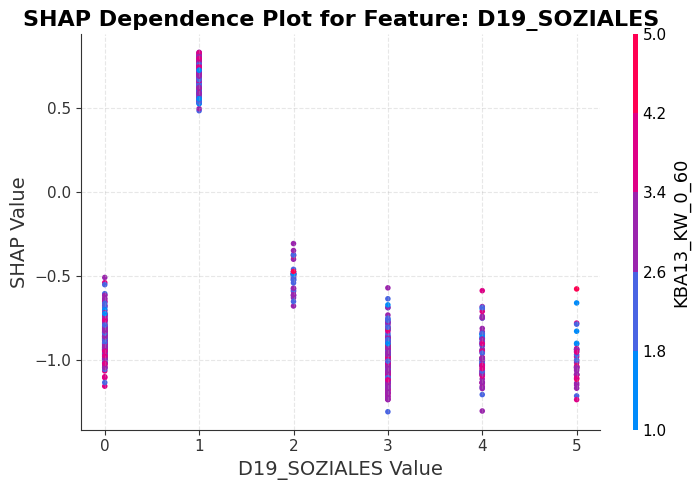

In [482]:
plot_shap_dependence(undersampled_model_xgb, X_train, y_train, "D19_SOZIALES")

We can notice that from the D19_SOZIALES categories, the category 1 has a direct influence on classification of customers, since above zero it contributes towadrs value 1 (our minority - customers).<br>
While it remains unknown what exactly does this category "1" mean, it is clear that it is the key to classification of customers. And that is the most we were able to find.

**Conclusion**

An extensive analysis was made with the goal of identifying patterns in the data distinguishing customers from non-customers of Arvato.<br>

**Customer Segmentation Analysis**
The first part of the analysis focused on segmentation clustering to uncover how customers differ from the general population based on socio-economic data.<br>
The results highlighted several key variables in the dataset where these differences were most visible.<br>

**Predictive model for classifying potential customers**<br>
The second part of the analysis aimed to train a predictive model capable of identifying potential customers based on historical data.<br>
This task was particularly challenging due to the significant class imbalance in the dataset.<br>

To address this, several techniques were employed:<br>
- Undersampling to balance the dataset.
- Bootstrap aggregation (bagging) to make better use of the data.
- Experimentation with different models to improve classification performance.

Among all approaches, the best results were achieved by training a single XGBoost classifier on an undersampled dataset.

The best score reached was a Precision Recall score of 0.62 which, while far from perfect, show moderate ability to identify customers in the data. Far better than a random guess.<br>
From the analysis of model's feature importances and SHAP dependency of the most important variable - a value in the data was indentified, which likely contributes the most to the probability of a person being a customer.

**Points for Improvement in Customer Segmentation and Predictive Modeling**<br>
While the current analysis achieved valuable results, several areas can be improved to enhance model performance and insights:<br>

1. Improved Feature Engineering<br>
Better understanding of the dataset’s features would definitely help the most. Techniques like creating interaction terms, domain-specific transformations, or leveraging SHAP for automated feature selection could refine the model further.
This was not possible due to limited information about dataset columns meaning.

2. Advanced modeling approaches <br>
Using deep learning or classifier ensemble meta learning would probably increase the accuracy of the prediction, at a higher computational cost. However it still makes sense mostly only when Feature engineering is significantly improved.